In [1]:
using DifferentialEquations
using Distributions
using HypergeometricFunctions
using HypothesisTests
using Interpolations
using LinearAlgebra
using LsqFit
using NLsolve
using Printf
using PyPlot
using QuadGK
using SpecialFunctions
using Statistics

In [2]:
sr2 = √(2)
sr2π = √(2π)

2.5066282746310002

# Rate Moment Calculator

In [3]:
abstract type RateParams end

In [4]:
struct RicciardiParams <: RateParams
    θ::AbstractFloat
    Vr::AbstractFloat
    σn::AbstractFloat
    τs::AbstractFloat
    τr::AbstractFloat
end

In [5]:
function μtox(μ::AbstractFloat)::AbstractFloat
    sign(μ/100-0.2)*abs(μ/100-0.2)^0.5
end

function xtoμ(x::AbstractFloat)::AbstractFloat
    100(sign(x)*abs(x)^2.0+0.2)
end

xtoμ (generic function with 1 method)

In [6]:
function Φint(rp::RicciardiParams,μ::AbstractFloat)
    umax = (rp.θ-μ)/rp.σn
    umin = (rp.Vr-μ)/rp.σn
    if umin > 10
        return umax*exp(-umax^2)/rp.τs
    elseif umin > -4
        return 1/(rp.τr+rp.τs*(0.5*π*(erfi(umax)-erfi(umin)) +
                umax^2*pFq([1.0,1.0],[1.5,2.0],umax^2) -
                umin^2*pFq([1.0,1.0],[1.5,2.0],umin^2)))
    else
        return 1/(rp.τr+rp.τs*(log(abs(umin))-log(abs(umax)) +
                (0.25umin^-2-0.1875umin^-4+0.3125umin^-6-
                    0.8203125umin^-8+2.953125umin^-10) -
                (0.25umax^-2-0.1875umax^-4+0.3125umax^-6-
                    0.8203125umax^-8+2.953125umax^-10)))
    end
end

function Φitp(rps::Vector{RicciardiParams})
    xs = range(μtox(-1E3), μtox(5E5), length=2*10^5+1)
    Φint(rps[1],-100.0)
    Φint(rps[1],0.0)
    Φint(rps[1],100.0)
    global Φitps = Dict()
    for rp in rps
        Φs = [Φint(rp,xtoμ(x)) for x in xs]
        Φitps[hash(rp)] = CubicSplineInterpolation(xs, Φs, extrapolation_bc = Line())
    end
end

function Φ(rp::RicciardiParams,μ::AbstractFloat)
    return Φitps[hash(rp)](μtox(μ))
end

Φ (generic function with 1 method)

In [7]:
function Mint(rp::RicciardiParams,μ::AbstractFloat,σ::AbstractFloat)
    if σ ≈ 0.0
        return Φ(rp,μ)
    end
    quadgk(x->exp(-0.5x^2)/sr2π*Φ(rp,μ+σ*x),-8,8,rtol=1e-8)[1]
end

function Mitp(rps::Vector{RicciardiParams})
    xs = range(μtox(-800.0), μtox(1000.0), length=3000+1)
    σs = range(0.0, 120.0, length=600+1)
    Mint(rps[1],0.0,1.0)
    global Mitps = Dict()
    for rp in rps
        Ms = [Mint(rp,xtoμ(x),σ) for x in xs, σ in σs]
        Mitps[hash(rp)] = CubicSplineInterpolation((xs,σs), Ms, extrapolation_bc = Line())
    end
end

function M(rp::RicciardiParams,μ::AbstractFloat,σ::AbstractFloat)
    return Mitps[hash(rp)](μtox(μ),σ)
end

M (generic function with 1 method)

In [8]:
function Cint(rp::RicciardiParams,μ1::AbstractFloat,μ2::AbstractFloat,
            σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if ρ ≈ 0.0
        return M(rp,μ1,σ1)*M(rp,μ2,σ2)
    end
    if σ1 ≈ 0.0 || σ2 ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/(σ1*σ2),1)
    end
    quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ1+sign(c)*σ1*√(abs(c))*x,σ1*√(1-abs(c)))*
        M(rp,μ2+σ2*√(abs(c))*x,σ2*√(1-abs(c))),-8,8,rtol=1e-8)[1]
end

function Cint(rp::RicciardiParams,μ::AbstractFloat,σ::AbstractFloat,ρ::AbstractFloat)
    if ρ ≈ 0.0
        return M(rp,μ,σ)^2
    end
    if σ ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/σ^2,1)
    end
    quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ+sign(c)*σ*√(abs(c))*x,σ*√(1-abs(c)))*
        M(rp,μ+σ*√(abs(c))*x,σ*√(1-abs(c))),-8,8,rtol=1e-8)[1]
end

function Citp(rps::Vector{RicciardiParams})
    xs = range(μtox(-400.0), μtox(200.0), length=300+1)
    σs = range(0.0, 120.0, length=360+1)
    cs = range(-0.1, 1.0, length=66+1)
    Cint(rps[1],0.0,0.0,1.0,1.0,0.0)
    global Citps = Dict()
    for rp in rps
        Cs = [Cint(rp,xtoμ(x),σ,σ^2*c) for x in xs, σ in σs, c in cs]
        Citps[hash(rp)] = CubicSplineInterpolation((xs,σs,cs), Cs,
            extrapolation_bc = Line())
    end
end

function C(rp::RicciardiParams,μ::AbstractFloat,σ::AbstractFloat,ρ::AbstractFloat)
    if σ ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/σ^2,1)
    end
    return Citps[hash(rp)](μtox(μ),σ,c)
end

C (generic function with 1 method)

In [9]:
rpE = RicciardiParams(20.0,10.0,10.0,0.02,0.002)
rpI = RicciardiParams(20.0,10.0,10.0,0.01,0.002)

RicciardiParams(20.0, 10.0, 10.0, 0.01, 0.002)

In [10]:
@time Φitp([rpE,rpI])

  4.441055 seconds (22.21 M allocations: 606.547 MiB, 5.16% gc time, 82.22% compilation time)


In [11]:
@time Mitp([rpE,rpI])

495.699349 seconds (12.21 G allocations: 189.065 GiB, 7.27% gc time, 0.36% compilation time)


In [12]:
@time Citp([rpE,rpI])

5971.066319 seconds (206.70 G allocations: 3.300 TiB, 8.35% gc time, 0.06% compilation time)


# Opto-Stimulated Rate Moment

In [13]:
abstract type OptoParams end

In [14]:
struct TruncNormOptoParams <: OptoParams
    f::AbstractFloat                # fraction potentially expressing opsin
    f̄::AbstractFloat                # true fraction unaffected by opsin
    s::AbstractFloat                # normalized std of opsin expression
    λL::AbstractFloat               # mean optogenetic stimulus voltage
end

function TruncNormOptoParams(f::AbstractFloat,s::AbstractFloat,λL::AbstractFloat)
    f̄ = 1-f*0.5*(1+erf(1/(s*sr2)))
    TruncNormOptoParams(f,f̄,s,λL)
end

TruncNormOptoParams

In [15]:
struct LogNormOptoParams <: OptoParams
    s::AbstractFloat                # normalized std of opsin expression
    λL::AbstractFloat               # mean optogenetic stimulus voltage
    μ::AbstractFloat                # mean of log opsin expression
    σ::AbstractFloat                # std of log opsin expression
end

function LogNormOptoParams(s::AbstractFloat,λL::AbstractFloat)
    σ2 = log(1+s^2)
    σ = √(σ2)
    μ = log(λL)-0.5σ2
    LogNormOptoParams(s,λL,μ,σ)
end

LogNormOptoParams

In [16]:
function ΦLint(op::TruncNormOptoParams,rp::RateParams,μ::AbstractFloat)
    int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*Φ(rp,μ+x*op.λL),
                0,10op.s,rtol=1e-8)[1]
    int += op.f̄*Φ(rp,μ)
    return int
end

function ΦLint(op::LogNormOptoParams,rp::RateParams,μ::AbstractFloat)
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*Φ(rp,μ+x),
        0,50op.λL,rtol=1e-8)[1]
end

function ΦLitp(op::OptoParams,rps::Vector{T}) where {T <: RateParams}
    xs = range(μtox(-1E3), μtox(1E5), length=10^5+1)
    ΦLint(op,rps[1],0.0)
    global ΦLitps = Dict()
    for rp in rps
        ΦLs = [ΦLint(op,rp,xtoμ(x)) for x in xs]
        ΦLitps[hash(rp)] = CubicSplineInterpolation(xs, ΦLs, extrapolation_bc = Line())
    end
end

function ΦL(op::OptoParams,rp::RateParams,μ::AbstractFloat)
    return ΦLitps[hash(rp)](μtox(μ))
end

ΦL (generic function with 1 method)

In [17]:
function MLint(op::TruncNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    if σ ≈ 0.0
        return ΦL(op,rp,μ)
    end
    int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*M(rp,μ+x*op.λL,σ),
                0,10op.s,rtol=1e-8)[1]
    int += op.f̄*M(rp,μ,σ)
    return int
end

function MLint(op::LogNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    if σ ≈ 0.0
        return ΦL(op,rp,μ)
    end
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*M(rp,μ+x,σ),
        0,50op.λL,rtol=1e-8)[1]
end

function MLitp(op::OptoParams,rps::Vector{T}) where {T <: RateParams}
    xs = range(μtox(-800.0), μtox(500.0), length=1900+1)
    σs = range(0.0, 60.0, length=800+1)
    MLint(op,rps[1],0.0,1.0)
    global MLitps = Dict()
    for rp in rps
        MLs = [MLint(op,rp,xtoμ(x),σ) for x in xs, σ in σs]
        MLitps[hash(rp)] = CubicSplineInterpolation((xs,σs), MLs,
            extrapolation_bc = Line())
    end
end

function ML(op::OptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat)
    return MLitps[hash(rp)](μtox(μ),σ)
end

ML (generic function with 1 method)

In [18]:
function CLint(op::TruncNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*
                Cint(rp,μ1+x*op.λL,μ2+x*op.λL,σ1,σ2,ρ),
                0,10op.s,rtol=1e-8)[1]
    int += op.f̄*Cint(rp,μ1,μ2,σ1,σ2,ρ)
    return int
end

function CLint(op::LogNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if ρ ≈ 0.0
        return quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*
            M(rp,μ1+x,σ1)*M(rp,μ2+x,σ2),0,50op.λL,rtol=1e-8)[1]
    end
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*
                Cint(rp,μ1+x,μ2+x,σ1,σ2,ρ),0,50op.λL,rtol=1e-8)[1]
end

function CLint(op::TruncNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,
        ρ::AbstractFloat)
    if ρ ≈ 0.0
        int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*M(rp,μ+x*op.λL,σ)^2,
                    0,10op.s,rtol=1e-8)[1]
    else
        int = quadgk(x->exp(-0.5((x-1)/op.s)^2)/(sr2π*op.s)*op.f*C(rp,μ+x*op.λL,σ,ρ),
                    0,10op.s,rtol=1e-8)[1]
    end
    int += op.f̄*C(rp,μ,σ,ρ)
    return int
end

function CLint(op::LogNormOptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,
        ρ::AbstractFloat)
    if ρ ≈ 0.0
        return quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*M(rp,μ+x,σ)^2,
                    0,50op.λL,rtol=1e-8)[1]
    end
    quadgk(x->exp(-0.5((log(x)-op.μ)/op.σ)^2)/(sr2π*op.σ*x)*
                C(rp,μ+x,σ,ρ),0,50op.λL,rtol=1e-8)[1]
end

function CLitp(op::OptoParams,rps::Vector{T}) where {T <: RateParams}
    xs = range(μtox(-400.0), μtox(100.0), length=250+1)
    σs = range(0.0, 60.0, length=240+1)
    cs = range(-0.1, 1.0, length=66+1)
    CLint(op,rps[1],0.0,1.0,0.0)
    global CLitps = Dict()
    for rp in rps
        CLs = [CLint(op,rp,xtoμ(x),σ,σ^2*c) for x in xs, σ in σs, c in cs]
        CLitps[hash(rp)] = CubicSplineInterpolation((xs,σs,cs), CLs,
            extrapolation_bc = Line())
    end
end

function CL(op::OptoParams,rp::RateParams,μ::AbstractFloat,σ::AbstractFloat,
        ρ::AbstractFloat)
    if σ ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/σ^2,1)
    end
    int = CLitps[hash(rp)](μtox(μ),σ,c)
    if isnan(int)
        println((μ,σ,ρ))
    end
    return int
#     return CLitps[hash(rp)](μtox(μ),σ,c)
#     return CLint(op,rp,μ,σ,ρ)
end

CL (generic function with 1 method)

In [19]:
function RLint(op::TruncNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if σ1 ≈ 0.0 || σ2 ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/(σ1*σ2),1)
    end
    int = quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ1+sign(c)*σ1*√(abs(c))*x,σ1*√(1-abs(c)))*
        ML(op,rp,μ2+σ2*√(abs(c))*x,σ2*√(1-abs(c))),-8,8,rtol=1e-8)[1]
    return int
end

function RLint(op::LogNormOptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    if σ1 ≈ 0.0 || σ2 ≈ 0.0
        c = 0.0
    else
        c = sign(ρ)*min(abs(ρ)/(σ1*σ2),1)
    end
    int = quadgk(x->exp(-0.5x^2)/sr2π*
        M(rp,μ1+sign(c)*σ1*√(abs(c))*x,σ1*√(1-abs(c)))*
        ML(op,rp,μ2+σ2*√(abs(c))*x,σ2*√(1-abs(c))),-8,8,rtol=1e-8)[1]
    return int
end

function RL(op::OptoParams,rp::RateParams,μ1::AbstractFloat,μ2::AbstractFloat,
        σ1::AbstractFloat,σ2::AbstractFloat,ρ::AbstractFloat)
    return RLint(op,rp,μ1,μ2,σ1,σ2,ρ)
end

RL (generic function with 1 method)

# Network Parameters Struct

In [25]:
struct NetworkParams
    K::Int                          # mean number of E->E connections
    p::AbstractFloat                # connection probability
    γ::AbstractFloat                # ratio of I vs E cells
    sX::AbstractFloat               # std/mean of external firing rates
    rpE::RateParams                 # rate params for excitatory cells
    rpI::RateParams                 # rate params for inhibitory cells
    W::Matrix{AbstractFloat}        # O(1) recurrent coupling matrix (EIX -> EI)
end

function NetworkParams(K::Int,p::AbstractFloat,γ::AbstractFloat,gE::AbstractFloat,
        gI::AbstractFloat,β::AbstractFloat,ΓE::AbstractFloat,ΓI::AbstractFloat,
        sX::AbstractFloat,rpE::RateParams,rpI::RateParams)
    W = [1.0 -gE (ΓI*γ*gE-ΓE);
        1/β -gI/β (ΓI*γ*gI-ΓE)/β]
    NetworkParams(K,p,γ,sX,rpE,rpI,W)
end

NetworkParams

# DMFT Solvers

In [54]:
function dmft(np::NetworkParams,J::AbstractFloat,rX::AbstractFloat,Twrm::AbstractFloat,
        Tsave::AbstractFloat,dt::AbstractFloat;DE::Function=t->0.0,DI::Function=t->0.0,
        rEinit::AbstractFloat=1E-8,rIinit::AbstractFloat=1E-8,
        CrEinit::Vector{Float64}=[1E2],CrIinit::Vector{Float64}=[1E2])
    Nint = round(Int,(Twrm+Tsave)/dt)+1
    Nclc = round(Int,1.5Tsave/dt)+1
    rE = Array{Float64}(undef,Nint)
    rI = Array{Float64}(undef,Nint)
    CrE = Array{Float64}(undef,(Nint,Nint))
    CrI = Array{Float64}(undef,(Nint,Nint))

    rE[1] = rEinit
    rI[1] = rIinit
    Nσ2init = length(CrEinit)
    if Nclc >= Nσ2init
        CrE[1,1:Nσ2init] .= CrEinit
        CrE[1,Nσ2init+1:Nclc] .= CrEinit[end]
        CrE[1:Nσ2init,1] .= CrEinit
        CrE[Nσ2init+1:Nclc,1] .= CrEinit[end]
    else
        CrE[1,1:Nclc] .= CrEinit[1:Nclc]
        CrE[1:Nclc,1] .= CrEinit[1:Nclc]
    end
    Nσ2init = length(CrIinit)
    if Nclc >= Nσ2init
        CrI[1,1:Nσ2init] .= CrIinit
        CrI[1,Nσ2init+1:Nclc] .= CrIinit[end]
        CrI[1:Nσ2init,1] .= CrIinit
        CrI[Nσ2init+1:Nclc,1] .= CrIinit[end]
    else
        CrI[1,1:Nclc] .= CrIinit[1:Nclc]
        CrI[1:Nclc,1] .= CrIinit[1:Nclc]
    end
    
    τE = np.rpE.τs
    τI = np.rpI.τs
    τE2 = τE^2
    τI2 = τI^2
    τEinv = 1/τE
    τIinv = 1/τI
    τEinv2 = τEinv^2
    τIinv2 = τIinv^2
    dtτEinv = dt*τEinv
    dtτIinv = dt*τIinv
    dtτEinv2 = dtτEinv^2
    dtτIinv2 = dtτIinv^2
    dt2 = dt^2
    
    q = 1-np.p
    
    JK = J*np.K
    τEJK = τE*JK
    τIJK = τI*JK
    J2K = J^2*np.K
    τE2J2K = τE2*J2K
    τI2J2K = τI2*J2K
    W2 = np.W.^2
    rX2 = rX^2
    σrX2 = (np.sX*rX)^2

    for i in 1:Nint-1
        rE2 = rE[i]^2
        rI2 = rI[i]^2
        σrE20 = CrE[i,i]-rE2
        σrI20 = CrI[i,i]-rI2
        μE = τEJK*(np.W[1,3]*rX+np.W[1,1]*rE[i]+np.γ*np.W[1,2]*rI[i])
        μI = τIJK*(np.W[2,3]*rX+np.W[2,1]*rE[i]+np.γ*np.W[2,2]*rI[i])
        σμE20 = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*rE2+np.γ*W2[1,2]*rI2) +
                        W2[1,3]*σrX2+W2[1,1]*σrE20+np.γ*W2[1,2]*σrI20)
        σμI20 = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*rE2+np.γ*W2[2,2]*rI2) +
                        W2[2,3]*σrX2+W2[2,1]*σrE20+np.γ*W2[2,2]*σrI20)
        kE1 = -τEinv*rE[i]+τEinv*M(rpE,μE,√(σμE20))
        kI1 = -τIinv*rI[i]+τIinv*M(rpI,μI,√(σμI20))
        σrE20k = max(CrE[i,i]-(rE[i]+0.5dt*kE1)^2,0)
        σrI20k = max(CrI[i,i]-(rI[i]+0.5dt*kI1)^2,0)
        μEk = τEJK*(np.W[1,3]*rX+np.W[1,1]*(rE[i]+0.5dt*kE1)+
                np.γ*np.W[1,2]*(rI[i]+0.5dt*kI1))
        μIk = τIJK*(np.W[2,3]*rX+np.W[2,1]*(rE[i]+0.5dt*kE1)+
                np.γ*np.W[2,2]*(rI[i]+0.5dt*kI1))
        σμE20k = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*(rE[i]+0.5dt*kE1)^2+
                            np.γ*W2[1,2]*(rI[i]+0.5dt*kI1)^2) +
                        W2[1,3]*σrX2+W2[1,1]*σrE20k+np.γ*W2[1,2]*σrI20k)
        σμI20k = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*(rE[i]+0.5dt*kE1)^2+
                            np.γ*W2[2,2]*(rI[i]+0.5dt*kI1)^2) +
                        W2[2,3]*σrX2+W2[2,1]*σrE20k+np.γ*W2[2,2]*σrI20k)
        kE2 = -τEinv*(rE[i]+0.5dt*kE1)+τEinv*M(rpE,μEk,√(σμE20k))
        kI2 = -τIinv*(rI[i]+0.5dt*kI1)+τIinv*M(rpI,μIk,√(σμI20k))
        σrE20k = max(CrE[i,i]-(rE[i]+0.5dt*kE2)^2,0)
        σrI20k = max(CrI[i,i]-(rI[i]+0.5dt*kI2)^2,0)
        μEk = τEJK*(np.W[1,3]*rX+np.W[1,1]*(rE[i]+0.5dt*kE2)+
                np.γ*np.W[1,2]*(rI[i]+0.5dt*kI2))
        μIk = τIJK*(np.W[2,3]*rX+np.W[2,1]*(rE[i]+0.5dt*kE2)+
                np.γ*np.W[2,2]*(rI[i]+0.5dt*kI2))
        σμE20k = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*(rE[i]+0.5dt*kE2)^2+
                            np.γ*W2[1,2]*(rI[i]+0.5dt*kI2)^2) +
                        W2[1,3]*σrX2+W2[1,1]*σrE20k+np.γ*W2[1,2]*σrI20k)
        σμI20k = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*(rE[i]+0.5dt*kE2)^2+
                            np.γ*W2[2,2]*(rI[i]+0.5dt*kI2)^2) +
                        W2[2,3]*σrX2+W2[2,1]*σrE20k+np.γ*W2[2,2]*σrI20k)
        kE3 = -τEinv*(rE[i]+0.5dt*kE2)+τEinv*M(rpE,μEk,√(σμE20k))
        kI3 = -τIinv*(rI[i]+0.5dt*kI2)+τIinv*M(rpI,μIk,√(σμI20k))
        σrE20k = max(CrE[i,i]-(rE[i]+dt*kE3)^2,0)
        σrI20k = max(CrI[i,i]-(rI[i]+dt*kI3)^2,0)
        μEk = τEJK*(np.W[1,3]*rX+np.W[1,1]*(rE[i]+dt*kE3)+
                np.γ*np.W[1,2]*(rI[i]+dt*kI3))
        μIk = τIJK*(np.W[2,3]*rX+np.W[2,1]*(rE[i]+dt*kE3)+
                np.γ*np.W[2,2]*(rI[i]+dt*kI3))
        σμE20k = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*(rE[i]+dt*kE3)^2+
                            np.γ*W2[1,2]*(rI[i]+dt*kI3)^2) +
                        W2[1,3]*σrX2+W2[1,1]*σrE20k+np.γ*W2[1,2]*σrI20k)
        σμI20k = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*(rE[i]+dt*kE3)^2+
                            np.γ*W2[2,2]*(rI[i]+dt*kI3)^2) +
                        W2[2,3]*σrX2+W2[2,1]*σrE20k+np.γ*W2[2,2]*σrI20k)
        kE4 = -τEinv*(rE[i]+dt*kE3)+τEinv*M(rpE,μEk,√(σμE20k))
        kI4 = -τIinv*(rI[i]+dt*kI3)+τIinv*M(rpI,μIk,√(σμI20k))
        rE[i+1] = rE[i] + dt/6*(kE1+2kE2+2kE3+kE4)
        rI[i+1] = rI[i] + dt/6*(kI1+2kI2+2kI3+kI4)
        if abs(rE[i+1]) > 1E10 || isnan(rE[i+1])
            @printf "CrE[%d,%d] = %f\n" i i CrE[i,i]
            @printf "CrI[%d,%d] = %f\n" i i CrI[i,i]
            @printf "rE[%d+1] = %f\n" i rE[i+1]
            @printf "rI[%d+1] = %f\n" i rI[i+1]
            @printf "μE = %f\n" μE
            @printf "μI = %f\n" μI
            @printf "σμE20 = %f\n" σμE20
            @printf "σμI20 = %f\n" σμI20
            println("system diverged")
            return (rE,rI,CrE,CrI)
        end
        if i > Nclc
            CrE[i+1,i-Nclc] = CrE[i,i-Nclc]
            CrI[i+1,i-Nclc] = CrI[i,i-Nclc]
        end
        for j in max(1,i-Nclc):i
            σrE2ij = CrE[i,j]-rE2
            σrI2ij = CrI[i,j]-rI2
            σμE2ij = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*rE2+np.γ*W2[1,2]*rI2) +
                            W2[1,3]*σrX2+W2[1,1]*σrE2ij+np.γ*W2[1,2]*σrI2ij)
            σμI2ij = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*rE2+np.γ*W2[2,2]*rI2) +
                            W2[2,3]*σrX2+W2[2,1]*σrE2ij+np.γ*W2[2,2]*σrI2ij)
            CrE[i+1,j+1] = CrE[i,j+1]+CrE[i+1,j]-CrE[i,j] -
                            dtτEinv*(CrE[i+1,j]+CrE[i,j+1]-2CrE[i,j]) - dtτEinv2*CrE[i,j] +
                            dtτEinv2*C(rpE,μE,√(σμE20),σμE2ij) + dtτEinv2*DE((j-i)*dt)
            CrI[i+1,j+1] = CrI[i,j+1]+CrI[i+1,j]-CrI[i,j] -
                            dtτIinv*(CrI[i+1,j]+CrI[i,j+1]-2CrI[i,j]) - dtτIinv2*CrI[i,j] +
                            dtτIinv2*C(rpI,μI,√(σμI20),σμI2ij) + dtτIinv2*DI((j-i)*dt)
            if CrE[i+1,j+1] > 1E10 || isnan(CrE[i+1,j+1])
                @printf "rE[%d] = %f\n" i rE[i]
                @printf "rI[%d] = %f\n" i rI[i]
                @printf "CrE[%d,%d] = %f\n" i j CrE[i,j]
                @printf "CrI[%d,%d] = %f\n" i j CrI[i,j]
                @printf "CrE[%d+1,%d] = %f\n" i j CrE[i+1,j]
                @printf "CrI[%d+1,%d] = %f\n" i j CrI[i+1,j]
                @printf "CrE[%d,%d+1] = %f\n" i j CrE[i,j+1]
                @printf "CrI[%d,%d+1] = %f\n" i j CrI[i,j+1]
                @printf "μE = %f\n" μE
                @printf "μI = %f\n" μI
                @printf "σμE20 = %f\n" σμE20
                @printf "σμI20 = %f\n" σμI20
                @printf "σμE2ij = %f\n" σμE2ij
                @printf "σμI2ij = %f\n" σμI2ij
                @printf "CrE[%d+1,%d+1] = %f\n" i j CrE[i+1,j+1]
                @printf "CrI[%d+1,%d+1] = %f\n" i j CrI[i+1,j+1]
                println("system diverged")
                return (rE,rI,CrE,CrI)
            end
            CrE[j+1,i+1] = CrE[i+1,j+1]
            CrI[j+1,i+1] = CrI[i+1,j+1]
        end
        ndiv = 5
        if (ndiv*i) % (Nint-1) == 0
#             @printf "%3d%% completed\n" round(Int,100*i/(Nint-1))
        end
    end
    
    Nsave = round(Int,(Tsave)/dt)+1
    return (rE[end],rI[end],
        CrE[end,end-Nsave+1:end],CrI[end,end-Nsave+1:end],
        abs(CrE[end,end]-CrE[end-Nsave+1,end-Nsave+1])/
        CrE[end-(Nsave÷2)+1,end-(Nsave÷2)+1] < 1E-5)
end

dmft (generic function with 1 method)

In [55]:
function optodmft(op::OptoParams,np::NetworkParams,J::AbstractFloat,rX::AbstractFloat,
        Twrm::AbstractFloat,Tsave::AbstractFloat,dt::AbstractFloat,rE::AbstractFloat,
        rI::AbstractFloat,CrE::Vector{Float64},CrI::Vector{Float64};
        ΔrEinit::AbstractFloat=rE/2,ΔrIinit::AbstractFloat=rI/2,
        CΔrEinit::Vector{Float64}=CrE,CΔrIinit::Vector{Float64}=CrI,
        RrEΔrEinit::Vector{Float64}=-CrE/2,RrIΔrIinit::Vector{Float64}=-CrI/2)
    Nint = round(Int,(Twrm+Tsave)/dt)+1
    Nclc = round(Int,1.5Tsave/dt)+1
    
    ΔrE = Array{Float64}(undef,Nint)
    ΔrI = Array{Float64}(undef,Nint)
    CΔrE = Array{Float64}(undef,(Nint,Nint))
    CΔrI = Array{Float64}(undef,(Nint,Nint))
    RrEΔrE = Array{Float64}(undef,(Nint,Nint))
    RrIΔrI = Array{Float64}(undef,(Nint,Nint))

    ΔrE[1] = ΔrEinit
    ΔrI[1] = ΔrIinit
    Nσ2init = length(CΔrEinit)
    if Nclc >= Nσ2init
        CΔrE[1,1:Nσ2init] .= CΔrEinit
        CΔrE[1,Nσ2init+1:Nclc] .= CΔrEinit[end]
        CΔrE[1:Nσ2init,1] .= CΔrEinit
        CΔrE[Nσ2init+1:Nclc,1] .= CΔrEinit[end]
    else
        CΔrE[1,1:Nclc] .= CΔrEinit[1:Nclc]
        CΔrE[1:Nclc,1] .= CΔrEinit[1:Nclc]
    end
    Nσ2init = length(CΔrIinit)
    if Nclc >= Nσ2init
        CΔrI[1,1:Nσ2init] .= CΔrIinit
        CΔrI[1,Nσ2init+1:Nclc] .= CΔrIinit[end]
        CΔrI[1:Nσ2init,1] .= CΔrIinit
        CΔrI[Nσ2init+1:Nclc,1] .= CΔrIinit[end]
    else
        CΔrI[1,1:Nclc] .= CΔrIinit[1:Nclc]
        CΔrI[1:Nclc,1] .= CΔrIinit[1:Nclc]
    end
    NRrIΔrInit = length(RrEΔrEinit)
    if Nclc >= NRrIΔrInit
        RrEΔrE[1,1:NRrIΔrInit] .= RrEΔrEinit
        RrEΔrE[1,NRrIΔrInit+1:Nclc] .= RrEΔrEinit[end]
        RrEΔrE[1:NRrIΔrInit,1] .= RrEΔrEinit
        RrEΔrE[NRrIΔrInit+1:Nclc,1] .= RrEΔrEinit[end]
    else
        RrEΔrE[1,1:Nclc] .= RrEΔrEinit[1:Nclc]
        RrEΔrE[1:Nclc,1] .= RrEΔrEinit[1:Nclc]
    end
    NRrIΔrInit = length(RrIΔrIinit)
    if Nclc >= NRrIΔrInit
        RrIΔrI[1,1:NRrIΔrInit] .= RrIΔrIinit
        RrIΔrI[1,NRrIΔrInit+1:Nclc] .= RrIΔrIinit[end]
        RrIΔrI[1:NRrIΔrInit,1] .= RrIΔrIinit
        RrIΔrI[NRrIΔrInit+1:Nclc,1] .= RrIΔrIinit[end]
    else
        RrIΔrI[1,1:Nclc] .= RrIΔrIinit[1:Nclc]
        RrIΔrI[1:Nclc,1] .= RrIΔrIinit[1:Nclc]
    end
    
    τE = np.rpE.τs
    τI = np.rpI.τs
    τE2 = τE^2
    τI2 = τI^2
    τEinv = 1/τE
    τIinv = 1/τI
    τEinv2 = τEinv^2
    τIinv2 = τIinv^2
    dtτEinv = dt*τEinv
    dtτIinv = dt*τIinv
    dtτEinv2 = dtτEinv^2
    dtτIinv2 = dtτIinv^2
    dt2 = dt^2
    
    q = 1-np.p
    
    JK = J*np.K
    τEJK = τE*JK
    τIJK = τI*JK
    J2K = J^2*np.K
    τE2J2K = τE2*J2K
    τI2J2K = τI2*J2K
    W2 = np.W.^2
    rX2 = rX^2
    σrX2 = (np.sX*rX)^2
    
    rE2 = rE^2
    rI2 = rI^2
    σrE2 = CrE.-rE2
    σrI2 = CrI.-rI2
    μE = τEJK*(np.W[1,3]*rX+np.W[1,1]*rE+np.γ*np.W[1,2]*rI)
    μI = τIJK*(np.W[2,3]*rX+np.W[2,1]*rE+np.γ*np.W[2,2]*rI)
    σμE2 = τE2J2K*(q*(W2[1,3]*rX2+W2[1,1]*rE2+np.γ*W2[1,2]*rI2) .+
                    W2[1,3]*σrX2.+W2[1,1]*σrE2.+np.γ*W2[1,2]*σrI2)
    σμI2 = τI2J2K*(q*(W2[2,3]*rX2+W2[2,1]*rE2+np.γ*W2[2,2]*rI2) .+
                    W2[2,3]*σrX2.+W2[2,1]*σrE2.+np.γ*W2[2,2]*σrI2)
    
    Nσ2 = length(σμE2)
    σμE20 = σμE2[1]
    σμI20 = σμI2[1]
    CrE0 = CrE[1]
    CrI0 = CrI[1]

    for i in 1:Nint-1
        ΔrE2 = ΔrE[i]^2
        ΔrI2 = ΔrI[i]^2
        rEΔrE = rE*ΔrE[i]
        rIΔrI = rI*ΔrI[i]
        σΔrE20 = CΔrE[i,i] - ΔrE2
        σΔrI20 = CΔrI[i,i] - ΔrI2
        ρrEΔrE0 = RrEΔrE[i,i] - rEΔrE
        ρrIΔrI0 = RrIΔrI[i,i] - rIΔrI
        ΔμE = τEJK*(np.W[1,1]*ΔrE[i]+np.γ*np.W[1,2]*ΔrI[i])
        ΔμI = τIJK*(np.W[2,1]*ΔrE[i]+np.γ*np.W[2,2]*ΔrI[i])
        σΔμE20 = τE2J2K*(q*(W2[1,1]*ΔrE2+np.γ*W2[1,2]*ΔrI2) +
                        W2[1,1]*σΔrE20+np.γ*W2[1,2]*σΔrI20)
        σΔμI20 = τI2J2K*(q*(W2[2,1]*ΔrE2+np.γ*W2[2,2]*ΔrI2) +
                        W2[2,1]*σΔrE20+np.γ*W2[2,2]*σΔrI20)
        ρμEΔμE0 = τE2J2K*(q*(W2[1,1]*rEΔrE+np.γ*W2[1,2]*rIΔrI) +
                        W2[1,1]*ρrEΔrE0+np.γ*W2[1,2]*ρrIΔrI0)
        ρμIΔμI0 = τI2J2K*(q*(W2[2,1]*rEΔrE+np.γ*W2[2,2]*rIΔrI) +
                        W2[2,1]*ρrEΔrE0+np.γ*W2[2,2]*ρrIΔrI0)
        σμpΔE20 = max(σμE20+σΔμE20+2ρμEΔμE0,0)
        σμpΔI20 = max(σμI20+σΔμI20+2ρμIΔμI0,0)
        kE1 = -τEinv*ΔrE[i]+τEinv*(ML(op,np.rpE,μE+ΔμE,√(σμpΔE20))-rE)
        kI1 = -τIinv*ΔrI[i]+τIinv*(M(np.rpI,μI+ΔμI,√(σμpΔI20))-rI)
        σΔrE20k = max(CΔrE[i,i] - (ΔrE[i]+0.5dt*kE1)^2,0)
        σΔrI20k = max(CΔrI[i,i] - (ΔrI[i]+0.5dt*kI1)^2,0)
        ρrEΔrE0k = RrEΔrE[i,i] - rE*(ΔrE[i]+0.5dt*kE1)
        ρrIΔrI0k = RrIΔrI[i,i] - rI*(ΔrI[i]+0.5dt*kI1)
        ΔμEk = τEJK*(np.W[1,1]*(ΔrE[i]+0.5dt*kE1)+np.γ*np.W[1,2]*(ΔrI[i]+0.5dt*kI1))
        ΔμIk = τIJK*(np.W[2,1]*(ΔrE[i]+0.5dt*kE1)+np.γ*np.W[2,2]*(ΔrI[i]+0.5dt*kI1))
        σΔμE20k = τE2J2K*(q*(W2[1,1]*(ΔrE[i]+0.5dt*kE1)^2+
                            np.γ*W2[1,2]*(ΔrI[i]+0.5dt*kI1)^2) +
                        W2[1,1]*σΔrE20k+np.γ*W2[1,2]*σΔrI20k)
        σΔμI20k = τI2J2K*(q*(W2[2,1]*(ΔrE[i]+0.5dt*kE1)^2+
                            np.γ*W2[2,2]*(ΔrI[i]+0.5dt*kI1)^2) +
                        W2[2,1]*σΔrE20k+np.γ*W2[2,2]*σΔrI20k)
        ρμEΔμE0k = τE2J2K*(q*(W2[1,1]*rE*(ΔrE[i]+0.5dt*kE1)+
                            np.γ*W2[1,2]*rI*(ΔrI[i]+0.5dt*kI1)) +
                        W2[1,1]*ρrEΔrE0k+np.γ*W2[1,2]*ρrIΔrI0k)
        ρμIΔμI0k = τI2J2K*(q*(W2[2,1]*rE*(ΔrE[i]+0.5dt*kE1)+
                            np.γ*W2[2,2]*rI*(ΔrI[i]+0.5dt*kI1)) +
                        W2[2,1]*ρrEΔrE0k+np.γ*W2[2,2]*ρrIΔrI0k)
        σμpΔE20k = max(σμE20+σΔμE20k+2ρμEΔμE0k,0)
        σμpΔI20k = max(σμI20+σΔμI20k+2ρμIΔμI0k,0)
        kE2 = -τEinv*(ΔrE[i]+0.5dt*kE1)+τEinv*(ML(op,np.rpE,μE+ΔμEk,√(σμpΔE20k))-rE)
        kI2 = -τIinv*(ΔrI[i]+0.5dt*kI1)+τIinv*(M(np.rpI,μI+ΔμIk,√(σμpΔI20k))-rI)
        σΔrE20k = max(CΔrE[i,i] - (ΔrE[i]+0.5dt*kE2)^2,0)
        σΔrI20k = max(CΔrI[i,i] - (ΔrI[i]+0.5dt*kI2)^2,0)
        ρrEΔrE0k = RrEΔrE[i,i] - rE*(ΔrE[i]+0.5dt*kE2)
        ρrIΔrI0k = RrIΔrI[i,i] - rI*(ΔrI[i]+0.5dt*kI2)
        ΔμEk = τEJK*(np.W[1,1]*(ΔrE[i]+0.5dt*kE2)+np.γ*np.W[1,2]*(ΔrI[i]+0.5dt*kI2))
        ΔμIk = τIJK*(np.W[2,1]*(ΔrE[i]+0.5dt*kE2)+np.γ*np.W[2,2]*(ΔrI[i]+0.5dt*kI2))
        σΔμE20k = τE2J2K*(q*(W2[1,1]*(ΔrE[i]+0.5dt*kE2)^2+
                            np.γ*W2[1,2]*(ΔrI[i]+0.5dt*kI2)^2) +
                        W2[1,1]*σΔrE20k+np.γ*W2[1,2]*σΔrI20k)
        σΔμI20k = τI2J2K*(q*(W2[2,1]*(ΔrE[i]+0.5dt*kE2)^2+
                            np.γ*W2[2,2]*(ΔrI[i]+0.5dt*kI2)^2) +
                        W2[2,1]*σΔrE20k+np.γ*W2[2,2]*σΔrI20k)
        ρμEΔμE0k = τE2J2K*(q*(W2[1,1]*rE*(ΔrE[i]+0.5dt*kE2)+
                            np.γ*W2[1,2]*rI*(ΔrI[i]+0.5dt*kI2)) +
                        W2[1,1]*ρrEΔrE0k+np.γ*W2[1,2]*ρrIΔrI0k)
        ρμIΔμI0k = τI2J2K*(q*(W2[2,1]*rE*(ΔrE[i]+0.5dt*kE2)+
                            np.γ*W2[2,2]*rI*(ΔrI[i]+0.5dt*kI2)) +
                        W2[2,1]*ρrEΔrE0k+np.γ*W2[2,2]*ρrIΔrI0k)
        σμpΔE20k = max(σμE20+σΔμE20k+2ρμEΔμE0k,0)
        σμpΔI20k = max(σμI20+σΔμI20k+2ρμIΔμI0k,0)
        kE3 = -τEinv*(ΔrE[i]+0.5dt*kE2)+τEinv*(ML(op,np.rpE,μE+ΔμEk,√(σμpΔE20k))-rE)
        kI3 = -τIinv*(ΔrI[i]+0.5dt*kI2)+τIinv*(M(np.rpI,μI+ΔμIk,√(σμpΔI20k))-rI)
        σΔrE20k = max(CΔrE[i,i] - (ΔrE[i]+dt*kE3)^2,0)
        σΔrI20k = max(CΔrI[i,i] - (ΔrI[i]+dt*kI3)^2,0)
        ρrEΔrE0k = RrEΔrE[i,i] - rE*(ΔrE[i]+dt*kE3)
        ρrIΔrI0k = RrIΔrI[i,i] - rI*(ΔrI[i]+dt*kI3)
        ΔμEk = τEJK*(np.W[1,1]*(ΔrE[i]+dt*kE3)+np.γ*np.W[1,2]*(ΔrI[i]+dt*kI3))
        ΔμIk = τIJK*(np.W[2,1]*(ΔrE[i]+dt*kE3)+np.γ*np.W[2,2]*(ΔrI[i]+dt*kI3))
        σΔμE20k = τE2J2K*(q*(W2[1,1]*(ΔrE[i]+dt*kE3)^2+
                            np.γ*W2[1,2]*(ΔrI[i]+dt*kI3)^2) +
                        W2[1,1]*σΔrE20k+np.γ*W2[1,2]*σΔrI20k)
        σΔμI20k = τI2J2K*(q*(W2[2,1]*(ΔrE[i]+dt*kE3)^2+
                            np.γ*W2[2,2]*(ΔrI[i]+dt*kI3)^2) +
                        W2[2,1]*σΔrE20k+np.γ*W2[2,2]*σΔrI20k)
        ρμEΔμE0k = τE2J2K*(q*(W2[1,1]*rE*(ΔrE[i]+dt*kE3)+
                            np.γ*W2[1,2]*rI*(ΔrI[i]+dt*kI3)) +
                        W2[1,1]*ρrEΔrE0k+np.γ*W2[1,2]*ρrIΔrI0k)
        ρμIΔμI0k = τI2J2K*(q*(W2[2,1]*rE*(ΔrE[i]+dt*kE3)+
                            np.γ*W2[2,2]*rI*(ΔrI[i]+dt*kI3)) +
                        W2[2,1]*ρrEΔrE0k+np.γ*W2[2,2]*ρrIΔrI0k)
        σμpΔE20k = max(σμE20+σΔμE20k+2ρμEΔμE0k,0)
        σμpΔI20k = max(σμI20+σΔμI20k+2ρμIΔμI0k,0)
        kE4 = -τEinv*(ΔrE[i]+dt*kE3)+τEinv*(ML(op,np.rpE,μE+ΔμEk,√(σμpΔE20k))-rE)
        kI4 = -τIinv*(ΔrI[i]+dt*kI3)+τIinv*(M(np.rpI,μI+ΔμIk,√(σμpΔI20k))-rI)
        ΔrE[i+1] = ΔrE[i] + dt/6*(kE1+2kE2+2kE3+kE4)
        ΔrI[i+1] = ΔrI[i] + dt/6*(kI1+2kI2+2kI3+kI4)
        if abs(ΔrE[i+1]) > 1E10 || isnan(ΔrE[i+1])
            @printf "CΔrE[%d,%d] = %f\n" i i CΔrE[i,i]
            @printf "CΔrI[%d,%d] = %f\n" i i CΔrI[i,i]
            @printf "ΔrE[%d+1] = %f\n" i ΔrE[i+1]
            @printf "ΔrI[%d+1] = %f\n" i ΔrI[i+1]
            @printf "ΔμE = %f\n" ΔμE
            @printf "ΔμI = %f\n" ΔμI
            @printf "σμpΔE20 = %f\n" σμpΔE20
            @printf "σμpΔI20 = %f\n" σμpΔI20
            println("system diverged")
            return (ΔrE,ΔrI,CΔrE,CΔrI)
        end
        if i > Nclc
            CΔrE[i+1,i-Nclc] = CΔrE[i,i-Nclc]
            CΔrI[i+1,i-Nclc] = CΔrI[i,i-Nclc]
            RrEΔrE[i+1,i-Nclc] = RrEΔrE[i,i-Nclc]
            RrIΔrI[i+1,i-Nclc] = RrIΔrI[i,i-Nclc]
        end
        for j in max(1,i-Nclc):i
            CrEij = abs(j-i) < Nσ2 ? CrE[abs(j-i)+1] : CrE[end]
            CrIij = abs(j-i) < Nσ2 ? CrI[abs(j-i)+1] : CrI[end]
            σΔrE2ij = CΔrE[i,j] - ΔrE2
            σΔrI2ij = CΔrI[i,j] - ΔrI2
            ρrEΔrEij = RrEΔrE[i,j] - rEΔrE
            ρrIΔrIij = RrIΔrI[i,j] - rIΔrI
            σμE2ij = abs(j-i) < Nσ2 ? σμE2[abs(j-i)+1] : σμE2[end]
            σμI2ij = abs(j-i) < Nσ2 ? σμI2[abs(j-i)+1] : σμI2[end]
            σΔμE2ij = τE2J2K*(q*(W2[1,1]*ΔrE2+np.γ*W2[1,2]*ΔrI2) +
                            W2[1,1]*σΔrE2ij+np.γ*W2[1,2]*σΔrI2ij)
            σΔμI2ij = τI2J2K*(q*(W2[2,1]*ΔrE2+np.γ*W2[2,2]*ΔrI2) +
                            W2[2,1]*σΔrE2ij+np.γ*W2[2,2]*σΔrI2ij)
            ρμEΔμEij = τE2J2K*(q*(W2[1,1]*rEΔrE+np.γ*W2[1,2]*rIΔrI) +
                            W2[1,1]*ρrEΔrEij+np.γ*W2[1,2]*ρrIΔrIij)
            ρμIΔμIij = τI2J2K*(q*(W2[2,1]*rEΔrE+np.γ*W2[2,2]*rIΔrI) +
                            W2[2,1]*ρrEΔrEij+np.γ*W2[2,2]*ρrIΔrIij)
            σμpΔE2ij = σμE2ij+σΔμE2ij+2ρμEΔμEij
            σμpΔI2ij = σμI2ij+σΔμI2ij+2ρμIΔμIij
            RrErEL = RL(op,np.rpE,μE,μE+ΔμE,√(σμE20),√(σμpΔE20),σμE2ij+ρμEΔμEij)
            RrIrIL = Cint(np.rpI,μI,μI+ΔμI,√(σμI20),√(σμpΔI20),σμI2ij+ρμIΔμIij)
            CΔrE[i+1,j+1] = CΔrE[i,j+1]+CΔrE[i+1,j]-CΔrE[i,j] -
                            dtτEinv*(CΔrE[i+1,j]+CΔrE[i,j+1]-2CΔrE[i,j]) -
                            dtτEinv2*CΔrE[i,j] +
                            dtτEinv2*(CL(op,np.rpE,μE+ΔμE,√(σμpΔE20),σμpΔE2ij)-
                                2RrErEL+CrEij)
            CΔrI[i+1,j+1] = CΔrI[i,j+1]+CΔrI[i+1,j]-CΔrI[i,j] -
                            dtτIinv*(CΔrI[i+1,j]+CΔrI[i,j+1]-2CΔrI[i,j]) -
                            dtτIinv2*CΔrI[i,j] +
                            dtτIinv2*(C(np.rpI,μI+ΔμI,√(σμpΔI20),σμpΔI2ij)-
                                2RrIrIL+CrIij)
            if CΔrE[i+1,j+1] > 1E10 || isnan(CΔrE[i+1,j+1])
                @printf "ΔrE[%d] = %f\n" i ΔrE[i]
                @printf "ΔrI[%d] = %f\n" i ΔrI[i]
                @printf "CΔrE[%d,%d] = %f\n" i i CΔrE[i,i]
                @printf "CΔrI[%d,%d] = %f\n" i i CΔrI[i,i]
                @printf "CΔrE = %f\n" CΔrE
                @printf "CΔrI = %f\n" CΔrI
                @printf "CΔrE[%d+1,%d+1] = %f\n" i j CΔrE[i+1,j+1]
                @printf "CΔrI[%d+1,%d+1] = %f\n" i j CΔrI[i+1,j+1]
                println("system diverged")
                return (ΔrE,ΔrI,CΔrE,CΔrI)
            end
            CΔrE[j+1,i+1] = CΔrE[i+1,j+1]
            CΔrI[j+1,i+1] = CΔrI[i+1,j+1]
            RrEΔrE[i+1,j+1] = RrEΔrE[i,j+1]+RrEΔrE[i+1,j]-RrEΔrE[i,j] -
                            dtτEinv*(RrEΔrE[i+1,j]+RrEΔrE[i,j+1]-2RrEΔrE[i,j]) -
                            dtτEinv2*RrEΔrE[i,j] + dtτEinv2*(RrErEL-CrEij)
            RrIΔrI[i+1,j+1] = RrIΔrI[i,j+1]+RrIΔrI[i+1,j]-RrIΔrI[i,j] -
                            dtτIinv*(RrIΔrI[i+1,j]+RrIΔrI[i,j+1]-2RrIΔrI[i,j]) -
                            dtτIinv2*RrIΔrI[i,j] + dtτIinv2*(RrIrIL-CrIij)
            RrEΔrE[j+1,i+1] = RrEΔrE[i+1,j+1]
            RrIΔrI[j+1,i+1] = RrIΔrI[i+1,j+1]
        end
        ndiv = 5
        if (ndiv*i) % (Nint-1) == 0
#             @printf "%3d%% completed\n" round(Int,100*i/(Nint-1))
        end
    end
    
    Nsave = round(Int,(Tsave)/dt)+1
    return (ΔrE[end],ΔrI[end],
        CΔrE[end,end-Nsave+1:end],CΔrI[end,end-Nsave+1:end],
        RrEΔrE[end,end-Nsave+1:end],RrIΔrI[end,end-Nsave+1:end],
        abs(CΔrE[end,end]-CΔrE[end-Nsave+1,end-Nsave+1])/
            CΔrE[end-(Nsave÷2)+1,end-(Nsave÷2)+1] < 1E-5)
end

optodmft (generic function with 1 method)

# Panels A & B

In [21]:
# function LogNormOptoParams(s::AbstractFloat,λL::AbstractFloat)
op = LogNormOptoParams(2.154435,20.0)

LogNormOptoParams(2.154435, 20.0, 2.130649288219479, 1.3153577348649392)

In [22]:
@time ΦLitp(op,[rpE])

 24.440354 seconds (699.31 M allocations: 10.914 GiB, 10.56% gc time, 11.08% compilation time)


In [23]:
@time MLitp(op,[rpE])

315.850949 seconds (8.98 G allocations: 137.343 GiB, 9.38% gc time, 0.39% compilation time)


In [24]:
@time CLitp(op,[rpE])

1194.320693 seconds (31.10 G allocations: 474.641 GiB, 8.55% gc time, 0.23% compilation time)


In [28]:
# function NetworkParams(K::Int,p::AbstractFloat,γ::AbstractFloat,gE::AbstractFloat,
#         gI::AbstractFloat,β::AbstractFloat,ΓE::AbstractFloat,ΓI::AbstractFloat,
#         sX::AbstractFloat,rpE::RateParams,rpI::RateParams)
np = NetworkParams(500,0.1,0.25,8.0,3.0,1.0,1.0,2.0,0.2,rpE,rpI)

NetworkParams(500, 0.1, 0.25, 0.2, RicciardiParams(20.0, 10.0, 10.0, 0.02, 0.002), RicciardiParams(20.0, 10.0, 10.0, 0.01, 0.002), AbstractFloat[1.0 -8.0 3.0; 1.0 -3.0 0.5])

## Panel A

In [67]:
JAs = [7.7e-2, 0.215, 0.599, 1.0]
rXAs = [0.5, 0.83405, 1.39128, 2.320794, 3.871318,
    6.457748, 10.772173, 17.969068, 29.974213, 50.0]
chAs = zeros(Bool,length(JAs),length(rXAs))
μEAs = zeros(length(JAs),length(rXAs))
μIAs = zeros(length(JAs),length(rXAs))
ΔμEAs = zeros(length(JAs),length(rXAs))
ΔμIAs = zeros(length(JAs),length(rXAs))
σμE2As = zeros(length(JAs),length(rXAs))
σμI2As = zeros(length(JAs),length(rXAs))
σΔμE2As = zeros(length(JAs),length(rXAs))
σΔμI2As = zeros(length(JAs),length(rXAs))
ρμEΔμEAs = zeros(length(JAs),length(rXAs))
ρμIΔμIAs = zeros(length(JAs),length(rXAs))
rEAs = zeros(length(JAs),length(rXAs))
rIAs = zeros(length(JAs),length(rXAs))
ΔrEAs = zeros(length(JAs),length(rXAs))
ΔrIAs = zeros(length(JAs),length(rXAs))
σrE2As = zeros(length(JAs),length(rXAs))
σrI2As = zeros(length(JAs),length(rXAs))
σΔrE2As = zeros(length(JAs),length(rXAs))
σΔrI2As = zeros(length(JAs),length(rXAs))
ρrEΔrEAs = zeros(length(JAs),length(rXAs))
ρrIΔrIAs = zeros(length(JAs),length(rXAs))

4×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [97]:
for i in [4], j in [6:10;]#i in eachindex(JAs), j in eachindex(rXAs)
    J = JAs[i]
    rX = rXAs[j]
    
    TWrm = 1.0
    TSave = 0.4
    dt = 0.002
    
    count = 1
    @time rE,rI,CrE,CrI,conv = dmft(np,J,rX,TWrm,TSave,dt)
    while !conv && count < 10
        @time rE,rI,CrE,CrI,conv = dmft(np,J,rX,TWrm,TSave,dt,rEinit=rE,rIinit=rI,
            CrEinit=CrE,CrIinit=CrI)
        count += 1
    end
    count = 1
    @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,np,J,rX,TWrm,TSave,dt,
        rE,rI,CrE,CrI)
    while !conv && count < 10
        @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,np,J,rX,TWrm,TSave,dt,
            rE,rI,CrE,CrI,ΔrEinit=ΔrE,ΔrIinit=ΔrI,CΔrEinit=CΔrE,CΔrIinit=CΔrI,
            RrEΔrEinit=RrEΔrE,RrIΔrIinit=RrIΔrI)
        count += 1
    end
    
    function extend(a::Vector{Float64},T::AbstractFloat,dt::AbstractFloat)::Matrix{Float64}
        oldn = length(a)
        newn = round(Int,T/dt)+1
        b = a[end]*ones((newn,newn))
        for i in 1:oldn
            b[i:i+oldn-1,i] .= a
            b[i,i:i+oldn-1] .= a
        end
        for i in 1:newn-oldn
            b[i+oldn:-1:i+1,i+oldn] .= a
            b[i+oldn,i+oldn:-1:i+1] .= a
        end
        return b
    end
    
    q = 1-np.p
    τEJK = np.rpE.τs*J*np.K
    τIJK = np.rpI.τs*J*np.K
    J2K = J^2*np.K
    τE2J2K = np.rpE.τs^2*J^2*np.K
    τI2J2K = np.rpE.τs^2*J^2*np.K
    W2 = np.W.^2
    σrX2 = (np.sX*rX)^2
    
    σrE2 = CrE.-rE^2
    σrI2 = CrI.-rI^2
    σΔrE2 = CΔrE.-ΔrE^2
    σΔrI2 = CΔrI.-ΔrI^2
    ρrEΔrE = RrEΔrE.-rE*ΔrE
    ρrIΔrI = RrIΔrI.-rI*ΔrI
    
    μE = τEJK*(np.W[1,3]*rX+np.W[1,1]*rE+np.γ*np.W[1,2]*rI)
    μI = τIJK*(np.W[2,3]*rX+np.W[2,1]*rE+np.γ*np.W[2,2]*rI)
    ΔμE = τEJK*(np.W[1,1]*ΔrE+np.γ*np.W[1,2]*ΔrI)
    ΔμI = τIJK*(np.W[2,1]*ΔrE+np.γ*np.W[2,2]*ΔrI)
    σμE2 = τE2J2K*(q*(W2[1,3]*rX^2+W2[1,1]*rE^2+np.γ*W2[1,2]*rI^2) .+
                    W2[1,3]*σrX2.+W2[1,1]*σrE2.+np.γ*W2[1,2]*σrI2)
    σμI2 = τI2J2K*(q*(W2[2,3]*rX^2+W2[2,1]*rE^2+np.γ*W2[2,2]*rI^2) .+
                    W2[2,3]*σrX2.+W2[2,1]*σrE2.+np.γ*W2[2,2]*σrI2)
    σΔμE2 = τE2J2K*(q*(W2[1,1]*ΔrE^2+np.γ*W2[1,2]*ΔrI^2) .+
                    W2[1,1]*σΔrE2.+np.γ*W2[1,2]*σΔrI2)
    σΔμI2 = τI2J2K*(q*(W2[2,1]*ΔrE^2+np.γ*W2[2,2]*ΔrI^2) .+
                    W2[2,1]*σΔrE2.+np.γ*W2[2,2]*σΔrI2)
    ρμEΔμE = τE2J2K*(q*(W2[1,1]*rE*ΔrE+np.γ*W2[1,2]*rI*ΔrI) .+
                    W2[1,1]*ρrEΔrE.+np.γ*W2[1,2]*ρrIΔrI)
    ρμIΔμI = τI2J2K*(q*(W2[2,1]*rE*ΔrE+np.γ*W2[2,2]*rI*ΔrI) .+
                    W2[2,1]*ρrEΔrE.+np.γ*W2[2,2]*ρrIΔrI)
    
    chAs[i,j] = abs(1-CrE[end]/CrE[1]) > 1E-3
    μEAs[i,j] = μE
    μIAs[i,j] = μI
    ΔμEAs[i,j] = ΔμE
    ΔμIAs[i,j] = ΔμI
    σμE2As[i,j] = mean(extend(σμE2,4.0,dt))
    σμI2As[i,j] = mean(extend(σμI2,4.0,dt))
    σΔμE2As[i,j] = mean(extend(σΔμE2,4.0,dt))
    σΔμI2As[i,j] = mean(extend(σΔμI2,4.0,dt))
    ρμEΔμEAs[i,j] = mean(extend(ρμEΔμE,4.0,dt))
    ρμIΔμIAs[i,j] = mean(extend(ρμIΔμI,4.0,dt))
    rEAs[i,j] = rE
    rIAs[i,j] = rI
    ΔrEAs[i,j] = ΔrE
    ΔrIAs[i,j] = ΔrI
    σrE2As[i,j] = mean(extend(σrE2,4.0,dt))
    σrI2As[i,j] = mean(extend(σrI2,4.0,dt))
    σΔrE2As[i,j] = mean(extend(σΔrE2,4.0,dt))
    σΔrI2As[i,j] = mean(extend(σΔrI2,4.0,dt))
    ρrEΔrEAs[i,j] = mean(extend(ρrEΔrE,4.0,dt))
    ρrIΔrIAs[i,j] = mean(extend(ρrIΔrI,4.0,dt))
    
    @printf "%d/%d completed\n" length(rXAs)*(i-1)+j length(JAs)*length(rXAs)
end

  1.105409 seconds (13.27 M allocations: 209.944 MiB, 22.18% gc time)
 90.715306 seconds (3.09 G allocations: 51.712 GiB, 10.72% gc time)
36/40 completed
  0.755046 seconds (13.27 M allocations: 209.944 MiB)
162.521540 seconds (5.71 G allocations: 96.022 GiB, 10.66% gc time)
37/40 completed
  0.476292 seconds (13.27 M allocations: 209.944 MiB)
200.323185 seconds (6.59 G allocations: 109.793 GiB, 10.36% gc time)
38/40 completed
  0.568139 seconds (13.27 M allocations: 209.944 MiB, 15.02% gc time)
  0.371564 seconds (13.27 M allocations: 209.944 MiB)
  0.381227 seconds (13.27 M allocations: 209.944 MiB)
  0.773076 seconds (13.27 M allocations: 209.944 MiB, 48.26% gc time)
  0.384639 seconds (13.27 M allocations: 209.944 MiB)
  0.564580 seconds (13.27 M allocations: 209.944 MiB)
  1.209603 seconds (13.27 M allocations: 209.944 MiB, 10.43% gc time)
  0.449104 seconds (13.27 M allocations: 209.944 MiB)
  0.421017 seconds (13.27 M allocations: 209.944 MiB, 14.11% gc time)
  0.361361 seconds 

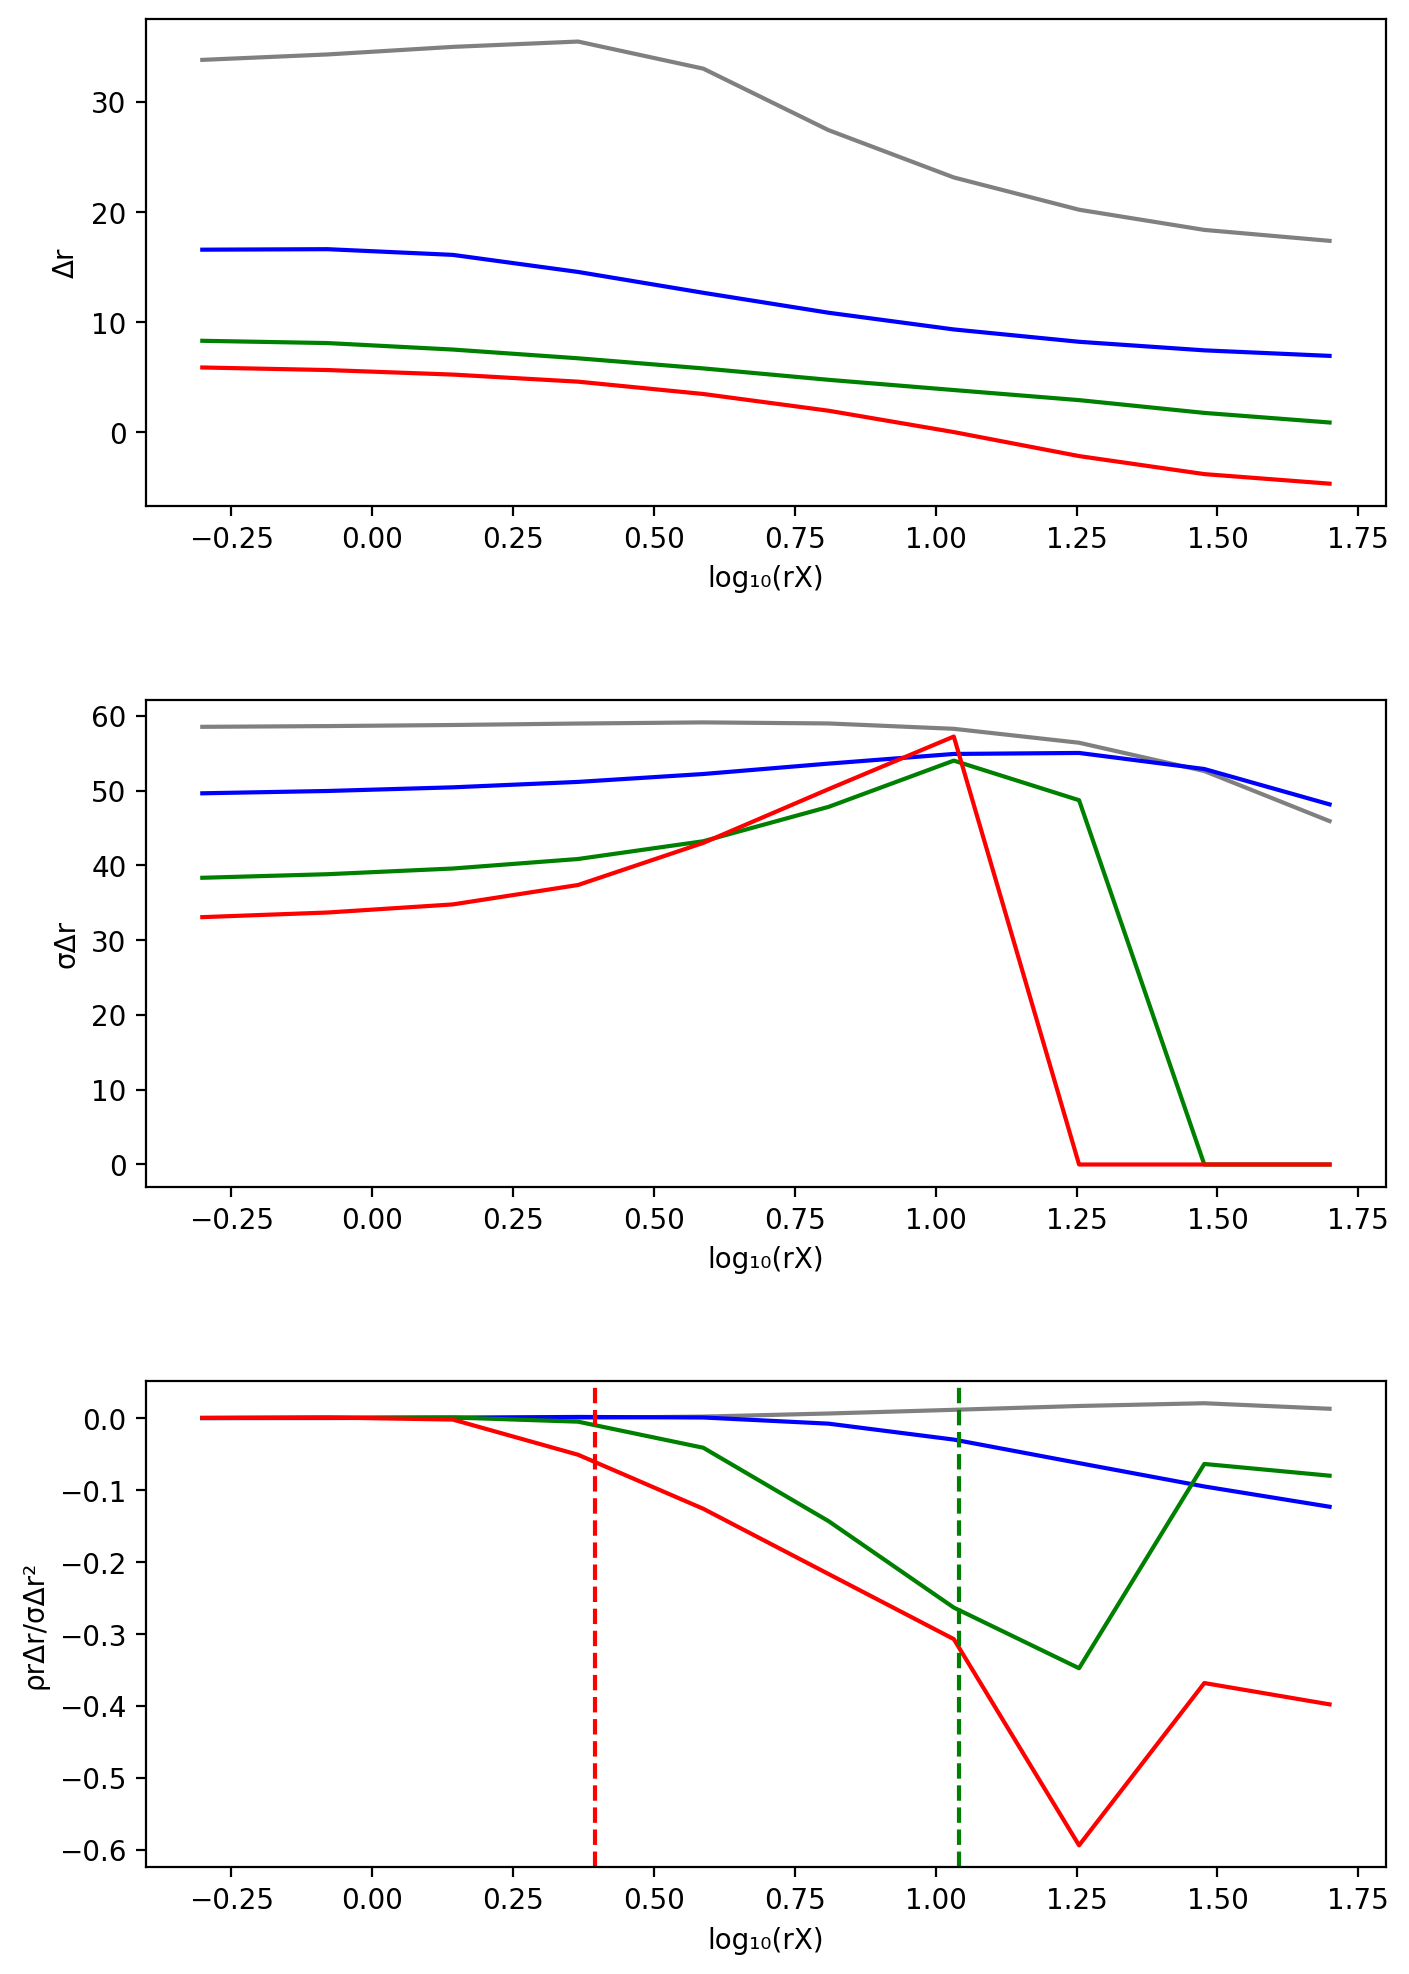

PyObject Text(48.000000000000014, 0.5, 'ρrΔr/σΔr²')

In [98]:
figure(figsize=(4*2,4*3),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(3,1,1)
plot(log10.(rXAs),0.8ΔrEAs[1,:]+0.2ΔrIAs[1,:],"gray")
plot(log10.(rXAs),0.8ΔrEAs[2,:]+0.2ΔrIAs[2,:],"b")
plot(log10.(rXAs),0.8ΔrEAs[3,:]+0.2ΔrIAs[3,:],"g")
plot(log10.(rXAs),0.8ΔrEAs[4,:]+0.2ΔrIAs[4,:],"r")
xlabel("log₁₀(rX)")
ylabel("Δr")

subplot(3,1,2)
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[1,:]+0.2σΔrI2As[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[2,:]+0.2σΔrI2As[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[3,:]+0.2σΔrI2As[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[4,:]+0.2σΔrI2As[4,:],0)),"r")
xlabel("log₁₀(rX)")
ylabel("σΔr")

subplot(3,1,3)
plot(log10.(rXAs),(0.8ρrEΔrEAs[1,:]+0.2ρrIΔrIAs[1,:])./
                    (0.8σΔrE2As[1,:]+0.2σΔrI2As[1,:]),"gray")
plot(log10.(rXAs),(0.8ρrEΔrEAs[2,:]+0.2ρrIΔrIAs[2,:])./
                    (0.8σΔrE2As[2,:]+0.2σΔrI2As[2,:]),"b")
plot(log10.(rXAs),(0.8ρrEΔrEAs[3,:]+0.2ρrIΔrIAs[3,:])./
                    (0.8σΔrE2As[3,:]+0.2σΔrI2As[3,:]),"g")
plot(log10.(rXAs),(0.8ρrEΔrEAs[4,:]+0.2ρrIΔrIAs[4,:])./
                    (0.8σΔrE2As[4,:]+0.2σΔrI2As[4,:]),"r")
if any(chAs[1,:])
    axvline(log10.(rXAs[findfirst(chAs[1,:])])-0.03,color="gray",ls="--")
end
if any(chAs[2,:])
    axvline(log10.(rXAs[findfirst(chAs[2,:])])-0.01,color="b",ls="--")
end
if any(chAs[3,:])
    axvline(log10.(rXAs[findfirst(chAs[3,:])])+0.01,color="g",ls="--")
end
if any(chAs[4,:])
    axvline(log10.(rXAs[findfirst(chAs[4,:])])+0.03,color="r",ls="--")
end
xlabel("log₁₀(rX)")
ylabel("ρrΔr/σΔr²")

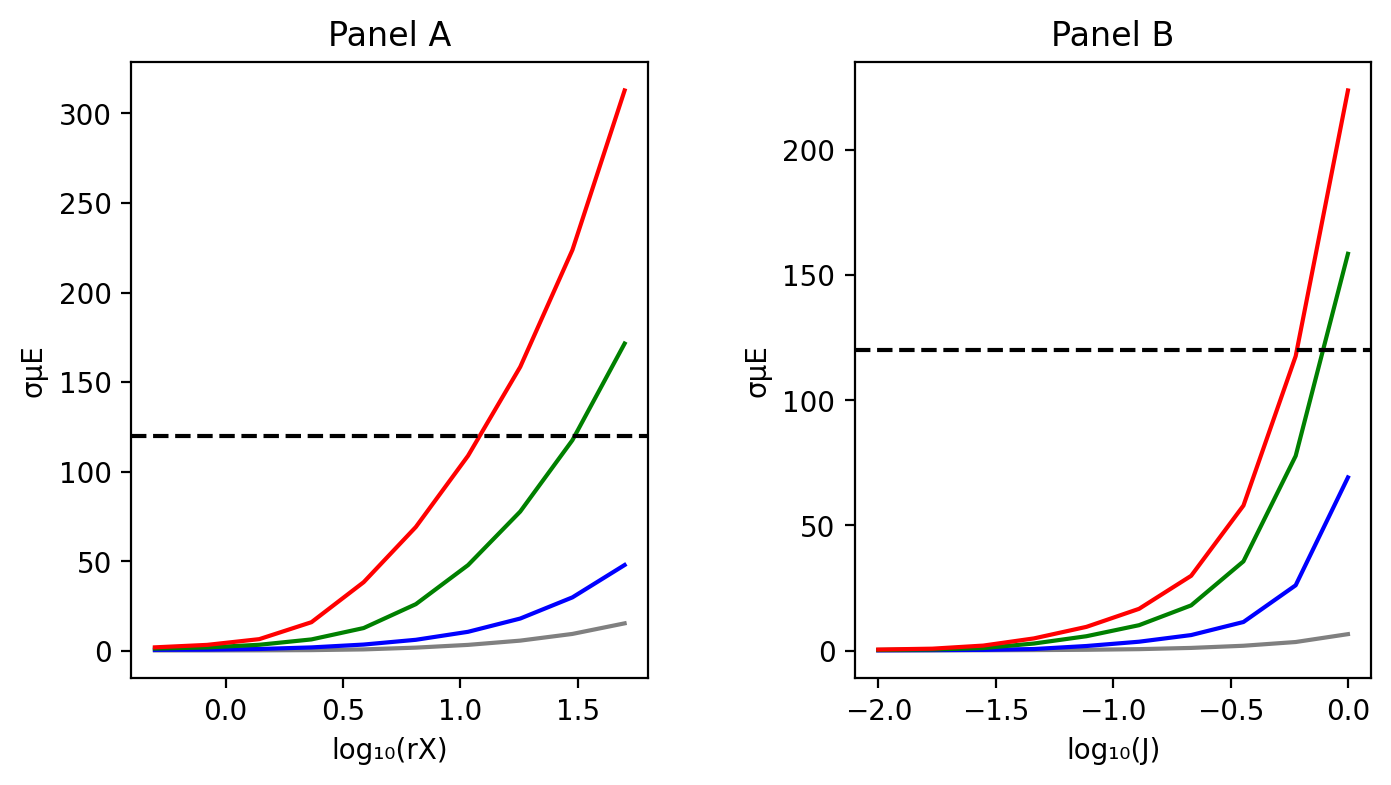

PyObject Text(0.5, 1.0, 'Panel B')

In [110]:
figure(figsize=(4*2,4),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(1,2,1)
plot(log10.(rXAs),.√(max.(σμE2As[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(σμE2As[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(σμE2As[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(σμE2As[4,:],0)),"r")
axhline(120,color="k",ls="--")
xlabel("log₁₀(rX)")
ylabel("σμE")
title("Panel A")

subplot(1,2,2)
plot(log10.(JBs),.√(max.(σμE2Bs[:,1],0)),"gray")
plot(log10.(JBs),.√(max.(σμE2Bs[:,2],0)),"b")
plot(log10.(JBs),.√(max.(σμE2Bs[:,3],0)),"g")
plot(log10.(JBs),.√(max.(σμE2Bs[:,4],0)),"r")
axhline(120,color="k",ls="--")
xlabel("log₁₀(J)")
ylabel("σμE")
title("Panel B")

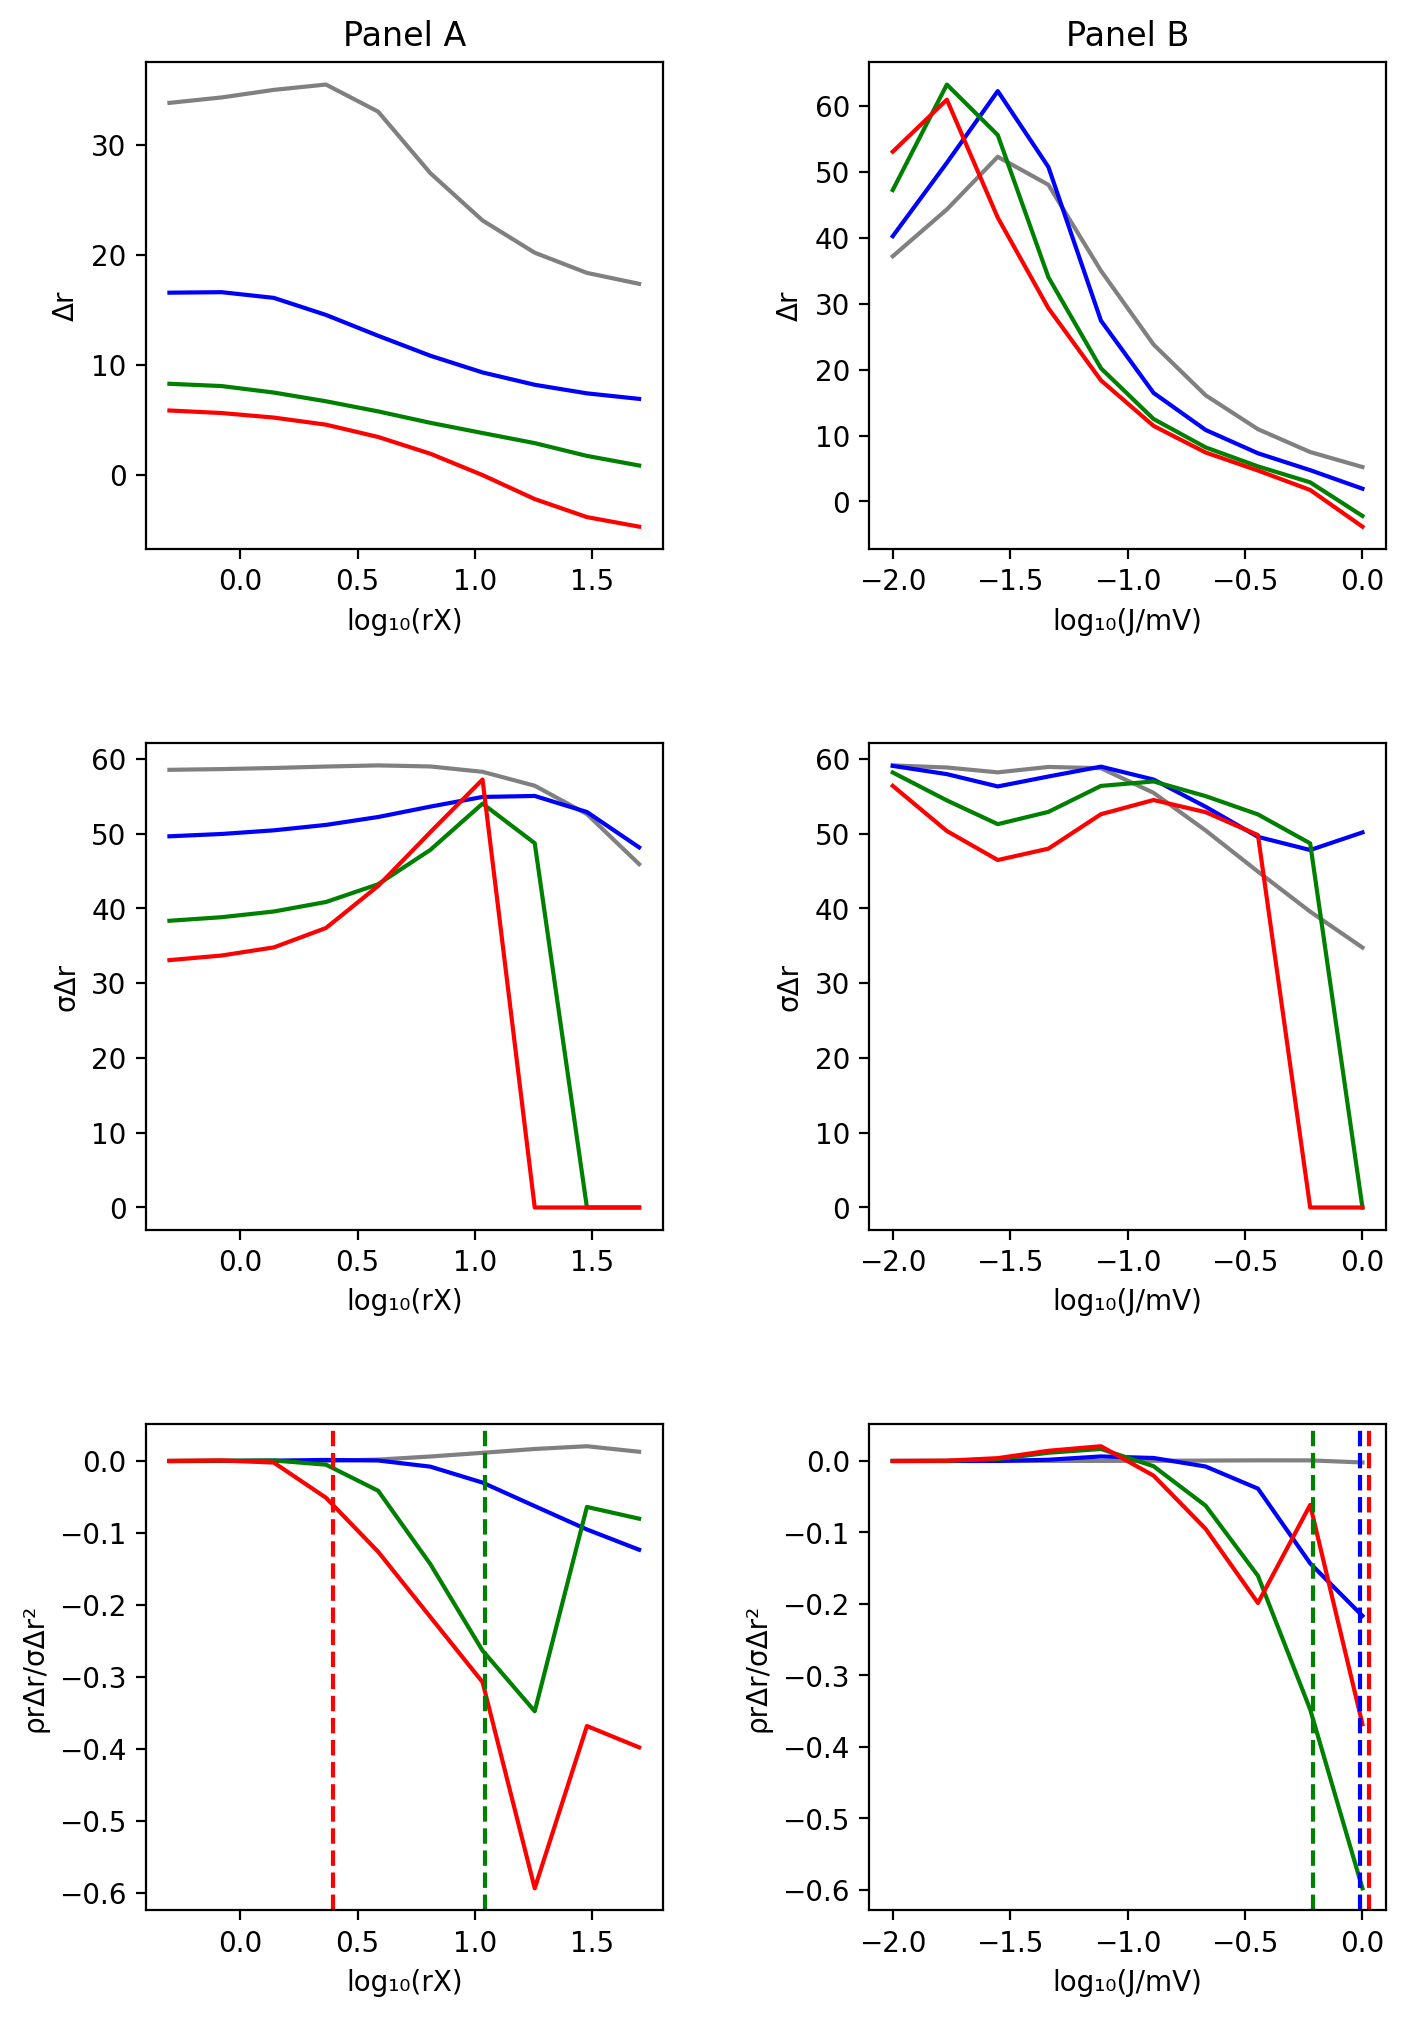

PyObject Text(771.3333333333335, 0.5, 'ρrΔr/σΔr²')

In [111]:
figure(figsize=(4*2,4*3),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(3,2,1)
plot(log10.(rXAs),0.8ΔrEAs[1,:]+0.2ΔrIAs[1,:],"gray")
plot(log10.(rXAs),0.8ΔrEAs[2,:]+0.2ΔrIAs[2,:],"b")
plot(log10.(rXAs),0.8ΔrEAs[3,:]+0.2ΔrIAs[3,:],"g")
plot(log10.(rXAs),0.8ΔrEAs[4,:]+0.2ΔrIAs[4,:],"r")
xlabel("log₁₀(rX)")
ylabel("Δr")
title("Panel A")

subplot(3,2,3)
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[1,:]+0.2σΔrI2As[1,:],0)),"gray")
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[2,:]+0.2σΔrI2As[2,:],0)),"b")
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[3,:]+0.2σΔrI2As[3,:],0)),"g")
plot(log10.(rXAs),.√(max.(0.8σΔrE2As[4,:]+0.2σΔrI2As[4,:],0)),"r")
xlabel("log₁₀(rX)")
ylabel("σΔr")

subplot(3,2,5)
plot(log10.(rXAs),(0.8ρrEΔrEAs[1,:]+0.2ρrIΔrIAs[1,:])./
                    (0.8σΔrE2As[1,:]+0.2σΔrI2As[1,:]),"gray")
plot(log10.(rXAs),(0.8ρrEΔrEAs[2,:]+0.2ρrIΔrIAs[2,:])./
                    (0.8σΔrE2As[2,:]+0.2σΔrI2As[2,:]),"b")
plot(log10.(rXAs),(0.8ρrEΔrEAs[3,:]+0.2ρrIΔrIAs[3,:])./
                    (0.8σΔrE2As[3,:]+0.2σΔrI2As[3,:]),"g")
plot(log10.(rXAs),(0.8ρrEΔrEAs[4,:]+0.2ρrIΔrIAs[4,:])./
                    (0.8σΔrE2As[4,:]+0.2σΔrI2As[4,:]),"r")
if any(chAs[1,:])
    axvline(log10.(rXAs[findfirst(chAs[1,:])])-0.03,color="gray",ls="--")
end
if any(chAs[2,:])
    axvline(log10.(rXAs[findfirst(chAs[2,:])])-0.01,color="b",ls="--")
end
if any(chAs[3,:])
    axvline(log10.(rXAs[findfirst(chAs[3,:])])+0.01,color="g",ls="--")
end
if any(chAs[4,:])
    axvline(log10.(rXAs[findfirst(chAs[4,:])])+0.03,color="r",ls="--")
end
xlabel("log₁₀(rX)")
ylabel("ρrΔr/σΔr²")

subplot(3,2,2)
plot(log10.(JBs),0.8ΔrEBs[:,1]+0.2ΔrIBs[:,1],"gray")
plot(log10.(JBs),0.8ΔrEBs[:,2]+0.2ΔrIBs[:,2],"b")
plot(log10.(JBs),0.8ΔrEBs[:,3]+0.2ΔrIBs[:,3],"g")
plot(log10.(JBs),0.8ΔrEBs[:,4]+0.2ΔrIBs[:,4],"r")
xlabel("log₁₀(J/mV)")
ylabel("Δr")
title("Panel B")

subplot(3,2,4)
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,1]+0.2σΔrI2Bs[:,1],0)),"gray")
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,2]+0.2σΔrI2Bs[:,2],0)),"b")
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,3]+0.2σΔrI2Bs[:,3],0)),"g")
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,4]+0.2σΔrI2Bs[:,4],0)),"r")
xlabel("log₁₀(J/mV)")
ylabel("σΔr")

subplot(3,2,6)
plot(log10.(JBs),(0.8ρrEΔrEBs[:,1]+0.2ρrIΔrIBs[:,1])./
                    (0.8σΔrE2Bs[:,1]+0.2σΔrI2Bs[:,1]),"gray")
plot(log10.(JBs),(0.8ρrEΔrEBs[:,2]+0.2ρrIΔrIBs[:,2])./
                    (0.8σΔrE2Bs[:,2]+0.2σΔrI2Bs[:,2]),"b")
plot(log10.(JBs),(0.8ρrEΔrEBs[:,3]+0.2ρrIΔrIBs[:,3])./
                    (0.8σΔrE2Bs[:,3]+0.2σΔrI2Bs[:,3]),"g")
plot(log10.(JBs),(0.8ρrEΔrEBs[:,4]+0.2ρrIΔrIBs[:,4])./
                    (0.8σΔrE2Bs[:,4]+0.2σΔrI2Bs[:,4]),"r")
if any(chBs[:,1])
    axvline(log10.(JBs[findfirst(chBs[:,1])])-0.03,color="gray",ls="--")
end
if any(chBs[:,2])
    axvline(log10.(JBs[findfirst(chBs[:,2])])-0.01,color="b",ls="--")
end
if any(chBs[:,3])
    axvline(log10.(JBs[findfirst(chBs[:,3])])+0.01,color="g",ls="--")
end
if any(chBs[:,4])
    axvline(log10.(JBs[findfirst(chBs[:,4])])+0.03,color="r",ls="--")
end
xlabel("log₁₀(J/mV)")
ylabel("ρrΔr/σΔr²")

## Panel B

In [73]:
JBs = [0.01, 0.017, 0.028, 0.046, 0.077, 0.129, 0.215, 0.359 ,0.599, 1.0]
rXBs = [1.39128, 6.457748, 17.969068, 29.974213]
chBs = zeros(Bool,length(JBs),length(rXBs))
μEBs = zeros(length(JBs),length(rXBs))
μIBs = zeros(length(JBs),length(rXBs))
ΔμEBs = zeros(length(JBs),length(rXBs))
ΔμIBs = zeros(length(JBs),length(rXBs))
σμE2Bs = zeros(length(JBs),length(rXBs))
σμI2Bs = zeros(length(JBs),length(rXBs))
σΔμE2Bs = zeros(length(JBs),length(rXBs))
σΔμI2Bs = zeros(length(JBs),length(rXBs))
ρμEΔμEBs = zeros(length(JBs),length(rXBs))
ρμIΔμIBs = zeros(length(JBs),length(rXBs))
rEBs = zeros(length(JBs),length(rXBs))
rIBs = zeros(length(JBs),length(rXBs))
ΔrEBs = zeros(length(JBs),length(rXBs))
ΔrIBs = zeros(length(JBs),length(rXBs))
σrE2Bs = zeros(length(JBs),length(rXBs))
σrI2Bs = zeros(length(JBs),length(rXBs))
σΔrE2Bs = zeros(length(JBs),length(rXBs))
σΔrI2Bs = zeros(length(JBs),length(rXBs))
ρrEΔrEBs = zeros(length(JBs),length(rXBs))
ρrIΔrIBs = zeros(length(JBs),length(rXBs))

10×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [103]:
for i in [9], j in [4]#i in eachindex(JBs), j in eachindex(rXBs)
    J = JBs[i]
    rX = rXBs[j]
    
    TWrm = 1.0
    TSave = 0.4
    dt = 0.002
    
    count = 1
    @time rE,rI,CrE,CrI,conv = dmft(np,J,rX,TWrm,TSave,dt)
    while !conv && count < 10
        @time rE,rI,CrE,CrI,conv = dmft(np,J,rX,TWrm,TSave,dt,rEinit=rE,rIinit=rI,
            CrEinit=CrE,CrIinit=CrI)
        count += 1
    end
    count = 1
    @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,np,J,rX,TWrm,TSave,dt,
        rE,rI,CrE,CrI)
    while !conv && count < 10
        @time ΔrE,ΔrI,CΔrE,CΔrI,RrEΔrE,RrIΔrI,conv = optodmft(op,np,J,rX,TWrm,TSave,dt,
            rE,rI,CrE,CrI,ΔrEinit=ΔrE,ΔrIinit=ΔrI,CΔrEinit=CΔrE,CΔrIinit=CΔrI,
            RrEΔrEinit=RrEΔrE,RrIΔrIinit=RrIΔrI)
        count += 1
    end
    
    function extend(a::Vector{Float64},T::AbstractFloat,dt::AbstractFloat)::Matrix{Float64}
        oldn = length(a)
        newn = round(Int,T/dt)+1
        b = a[end]*ones((newn,newn))
        for i in 1:oldn
            b[i:i+oldn-1,i] .= a
            b[i,i:i+oldn-1] .= a
        end
        for i in 1:newn-oldn
            b[i+oldn:-1:i+1,i+oldn] .= a
            b[i+oldn,i+oldn:-1:i+1] .= a
        end
        return b
    end
    
    q = 1-np.p
    τEJK = np.rpE.τs*J*np.K
    τIJK = np.rpI.τs*J*np.K
    J2K = J^2*np.K
    τE2J2K = np.rpE.τs^2*J^2*np.K
    τI2J2K = np.rpE.τs^2*J^2*np.K
    W2 = np.W.^2
    σrX2 = (np.sX*rX)^2
    
    σrE2 = CrE.-rE^2
    σrI2 = CrI.-rI^2
    σΔrE2 = CΔrE.-ΔrE^2
    σΔrI2 = CΔrI.-ΔrI^2
    ρrEΔrE = RrEΔrE.-rE*ΔrE
    ρrIΔrI = RrIΔrI.-rI*ΔrI
    
    μE = τEJK*(np.W[1,3]*rX+np.W[1,1]*rE+np.γ*np.W[1,2]*rI)
    μI = τIJK*(np.W[2,3]*rX+np.W[2,1]*rE+np.γ*np.W[2,2]*rI)
    ΔμE = τEJK*(np.W[1,1]*ΔrE+np.γ*np.W[1,2]*ΔrI)
    ΔμI = τIJK*(np.W[2,1]*ΔrE+np.γ*np.W[2,2]*ΔrI)
    σμE2 = τE2J2K*(q*(W2[1,3]*rX^2+W2[1,1]*rE^2+np.γ*W2[1,2]*rI^2) .+
                    W2[1,3]*σrX2.+W2[1,1]*σrE2.+np.γ*W2[1,2]*σrI2)
    σμI2 = τI2J2K*(q*(W2[2,3]*rX^2+W2[2,1]*rE^2+np.γ*W2[2,2]*rI^2) .+
                    W2[2,3]*σrX2.+W2[2,1]*σrE2.+np.γ*W2[2,2]*σrI2)
    σΔμE2 = τE2J2K*(q*(W2[1,1]*ΔrE^2+np.γ*W2[1,2]*ΔrI^2) .+
                    W2[1,1]*σΔrE2.+np.γ*W2[1,2]*σΔrI2)
    σΔμI2 = τI2J2K*(q*(W2[2,1]*ΔrE^2+np.γ*W2[2,2]*ΔrI^2) .+
                    W2[2,1]*σΔrE2.+np.γ*W2[2,2]*σΔrI2)
    ρμEΔμE = τE2J2K*(q*(W2[1,1]*rE*ΔrE+np.γ*W2[1,2]*rI*ΔrI) .+
                    W2[1,1]*ρrEΔrE.+np.γ*W2[1,2]*ρrIΔrI)
    ρμIΔμI = τI2J2K*(q*(W2[2,1]*rE*ΔrE+np.γ*W2[2,2]*rI*ΔrI) .+
                    W2[2,1]*ρrEΔrE.+np.γ*W2[2,2]*ρrIΔrI)
    
    chBs[i,j] = abs(1-CrE[end]/CrE[1]) > 1E-3
    μEBs[i,j] = μE
    μIBs[i,j] = μI
    ΔμEBs[i,j] = ΔμE
    ΔμIBs[i,j] = ΔμI
    σμE2Bs[i,j] = mean(extend(σμE2,4.0,dt))
    σμI2Bs[i,j] = mean(extend(σμI2,4.0,dt))
    σΔμE2Bs[i,j] = mean(extend(σΔμE2,4.0,dt))
    σΔμI2Bs[i,j] = mean(extend(σΔμI2,4.0,dt))
    ρμEΔμEBs[i,j] = mean(extend(ρμEΔμE,4.0,dt))
    ρμIΔμIBs[i,j] = mean(extend(ρμIΔμI,4.0,dt))
    rEBs[i,j] = rE
    rIBs[i,j] = rI
    ΔrEBs[i,j] = ΔrE
    ΔrIBs[i,j] = ΔrI
    σrE2Bs[i,j] = mean(extend(σrE2,4.0,dt))
    σrI2Bs[i,j] = mean(extend(σrI2,4.0,dt))
    σΔrE2Bs[i,j] = mean(extend(σΔrE2,4.0,dt))
    σΔrI2Bs[i,j] = mean(extend(σΔrI2,4.0,dt))
    ρrEΔrEBs[i,j] = mean(extend(ρrEΔrE,4.0,dt))
    ρrIΔrIBs[i,j] = mean(extend(ρrIΔrI,4.0,dt))
    
    @printf "%d/%d completed\n" length(rXBs)*(i-1)+j length(JBs)*length(rXBs)
end

  1.226943 seconds (13.27 M allocations: 209.944 MiB, 11.83% gc time)
  1.130039 seconds (13.27 M allocations: 209.944 MiB)
195.116631 seconds (6.09 G allocations: 101.702 GiB, 10.03% gc time)
36/40 completed


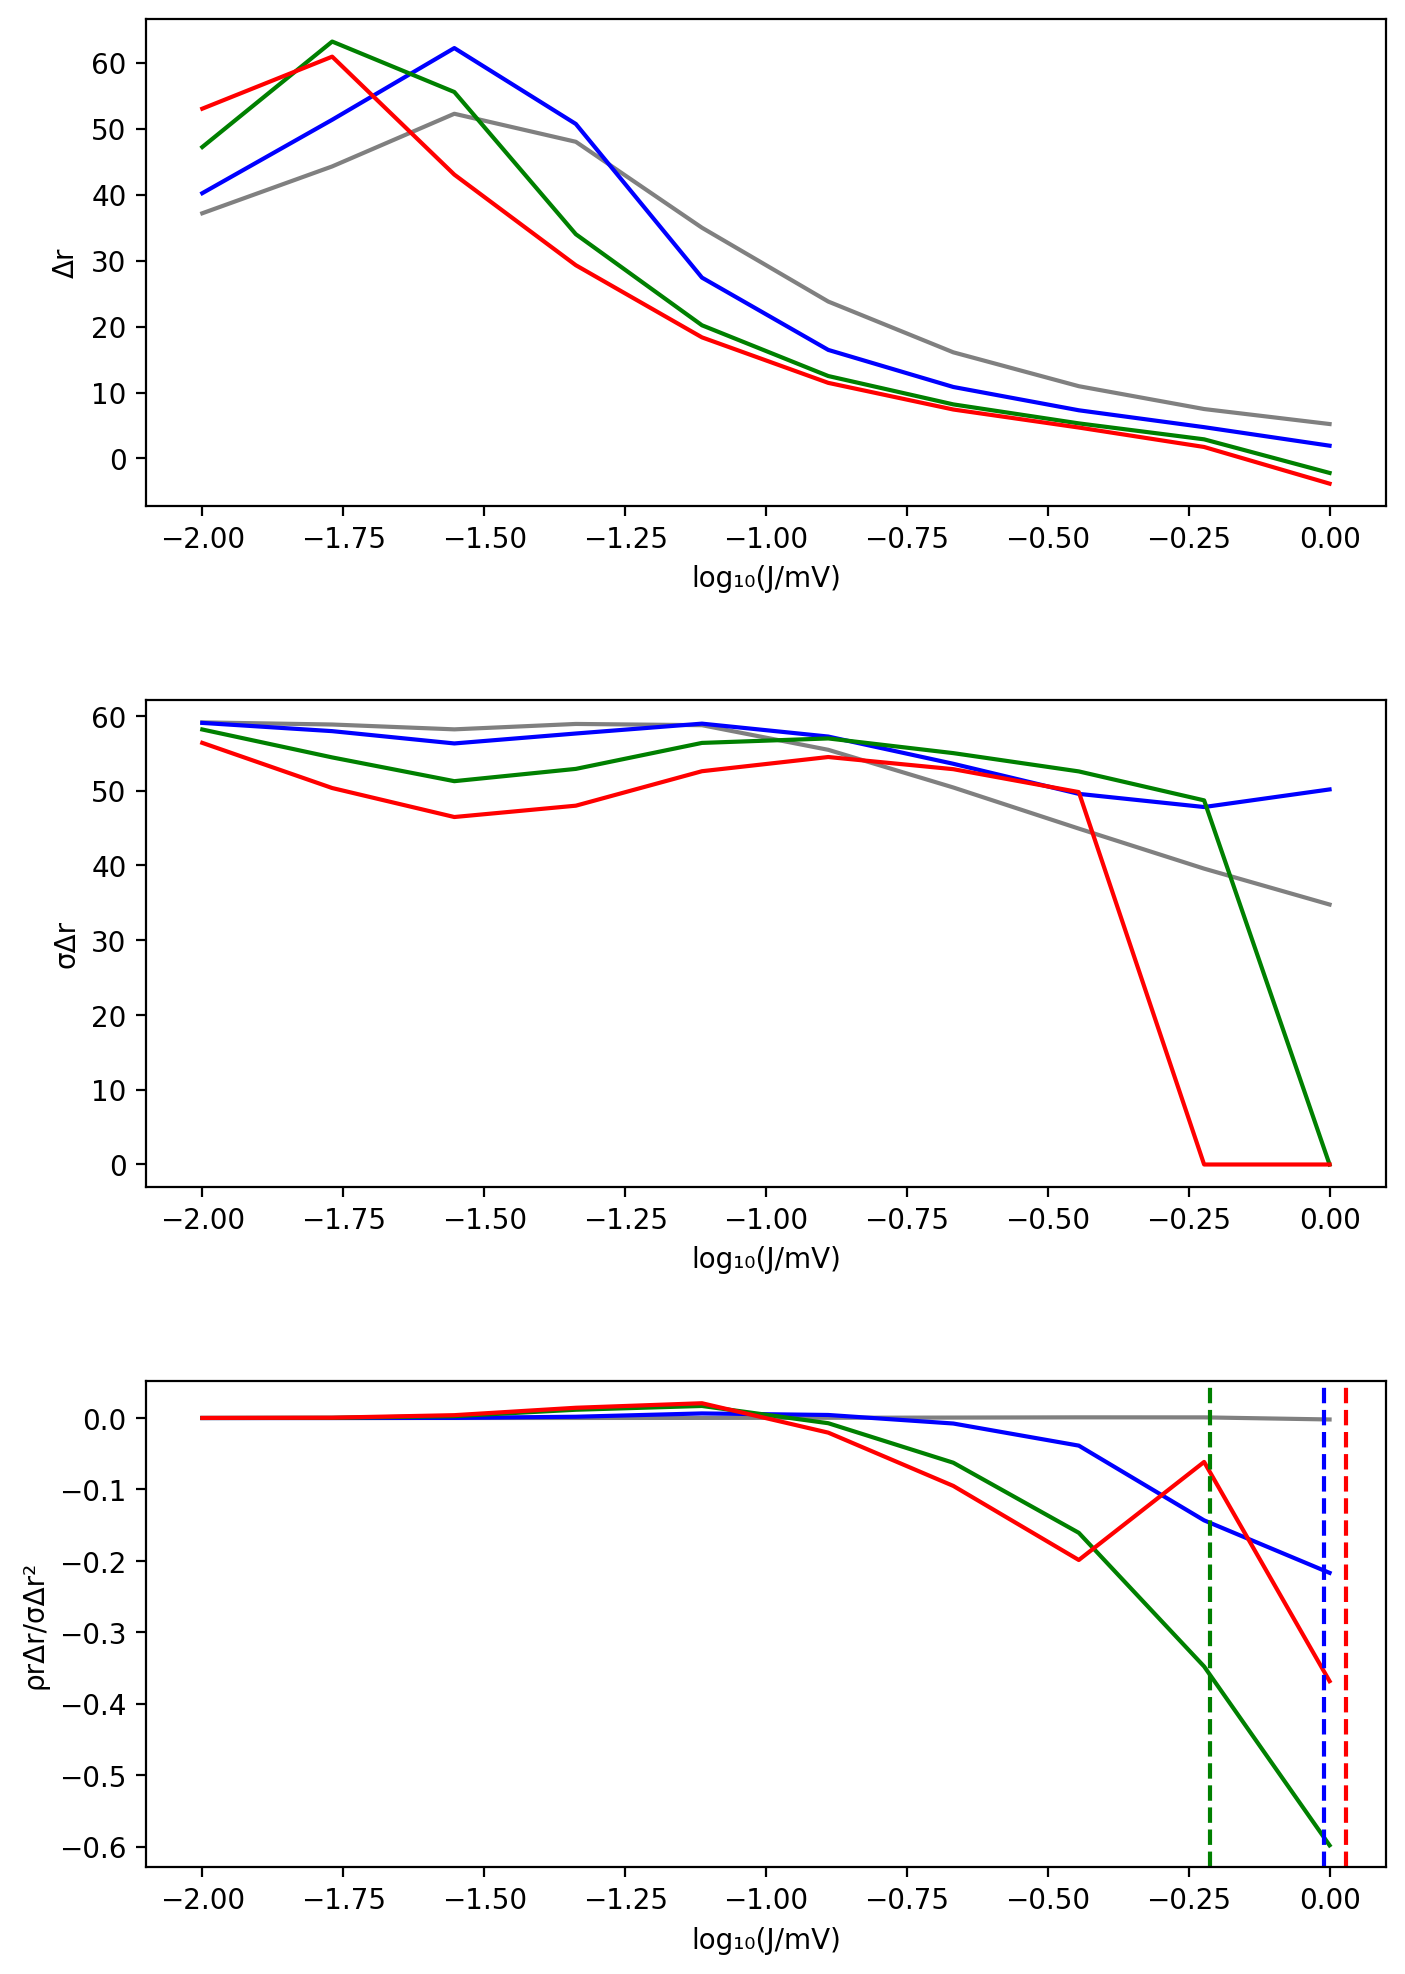

PyObject Text(48.000000000000014, 0.5, 'ρrΔr/σΔr²')

In [104]:
figure(figsize=(4*2,4*3),dpi=200)
subplots_adjust(hspace=0.4,wspace=0.4)

subplot(3,1,1)
plot(log10.(JBs),0.8ΔrEBs[:,1]+0.2ΔrIBs[:,1],"gray")
plot(log10.(JBs),0.8ΔrEBs[:,2]+0.2ΔrIBs[:,2],"b")
plot(log10.(JBs),0.8ΔrEBs[:,3]+0.2ΔrIBs[:,3],"g")
plot(log10.(JBs),0.8ΔrEBs[:,4]+0.2ΔrIBs[:,4],"r")
xlabel("log₁₀(J/mV)")
ylabel("Δr")

subplot(3,1,2)
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,1]+0.2σΔrI2Bs[:,1],0)),"gray")
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,2]+0.2σΔrI2Bs[:,2],0)),"b")
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,3]+0.2σΔrI2Bs[:,3],0)),"g")
plot(log10.(JBs),.√(max.(0.8σΔrE2Bs[:,4]+0.2σΔrI2Bs[:,4],0)),"r")
xlabel("log₁₀(J/mV)")
ylabel("σΔr")

subplot(3,1,3)
plot(log10.(JBs),(0.8ρrEΔrEBs[:,1]+0.2ρrIΔrIBs[:,1])./
                    (0.8σΔrE2Bs[:,1]+0.2σΔrI2Bs[:,1]),"gray")
plot(log10.(JBs),(0.8ρrEΔrEBs[:,2]+0.2ρrIΔrIBs[:,2])./
                    (0.8σΔrE2Bs[:,2]+0.2σΔrI2Bs[:,2]),"b")
plot(log10.(JBs),(0.8ρrEΔrEBs[:,3]+0.2ρrIΔrIBs[:,3])./
                    (0.8σΔrE2Bs[:,3]+0.2σΔrI2Bs[:,3]),"g")
plot(log10.(JBs),(0.8ρrEΔrEBs[:,4]+0.2ρrIΔrIBs[:,4])./
                    (0.8σΔrE2Bs[:,4]+0.2σΔrI2Bs[:,4]),"r")
if any(chBs[:,1])
    axvline(log10.(JBs[findfirst(chBs[:,1])])-0.03,color="gray",ls="--")
end
if any(chBs[:,2])
    axvline(log10.(JBs[findfirst(chBs[:,2])])-0.01,color="b",ls="--")
end
if any(chBs[:,3])
    axvline(log10.(JBs[findfirst(chBs[:,3])])+0.01,color="g",ls="--")
end
if any(chBs[:,4])
    axvline(log10.(JBs[findfirst(chBs[:,4])])+0.03,color="r",ls="--")
end
xlabel("log₁₀(J/mV)")
ylabel("ρrΔr/σΔr²")

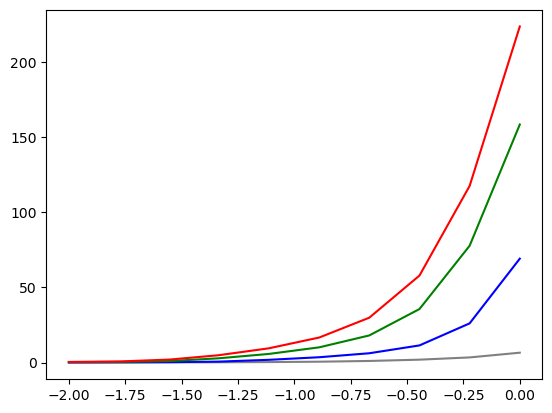

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc77f109580>

In [105]:
plot(log10.(JBs),.√(max.(σμE2Bs[:,1],0)),"gray")
plot(log10.(JBs),.√(max.(σμE2Bs[:,2],0)),"b")
plot(log10.(JBs),.√(max.(σμE2Bs[:,3],0)),"g")
plot(log10.(JBs),.√(max.(σμE2Bs[:,4],0)),"r")

# Panel C

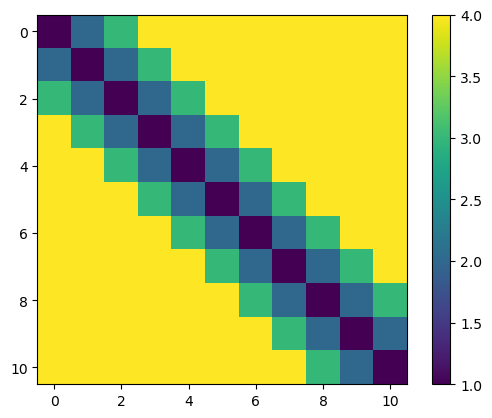

PyObject <matplotlib.colorbar.Colorbar object at 0x7fc81e380100>

In [63]:
# function LogNormOptoParams(s::AbstractFloat,λL::AbstractFloat)
op = LogNormOptoParams(1.0,20.0)

In [ ]:
@time ΦLitp(op,[rpE])

In [ ]:
@time MLitp(op,[rpE])

In [ ]:
@time CLitp(op,[rpE])

# Panel D